# **Virtual personas - Dataset preparation**

The following code:

*   Loads the dataset of ca. 11,000 pre-generated backstories generated by [Moon et al. (2024)](https://arxiv.org/abs/2407.06576) and publicly provided on [Github](https://github.com/CannyLab/anthology).
*   Performs some minor data cleaning
*   Enriches the data set with further variables via a prompting approach to prepare it for further matching with original studies



**A. Setup**

In [ ]:
!pip install openai

ERROR: Operation cancelled by user


In [ ]:
import os
import random
import itertools
import re
import pandas as pd
import seaborn as sns
import numpy as np
import time
import requests
import json
import scipy.stats as st
from scipy.stats import truncnorm
from patsy import dmatrix
import statsmodels.api as sm
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import drive
from openai import OpenAI

In [ ]:
RANDOM_STATE = 42
API_KEY = "sk-MxdFI8O2pu8XVYRvcnU0nw" # UniGPT API-Key

**B. Loading dataset**

In [ ]:
drive.mount('/content/drive')
path_to_pkl = "/content/drive/My Drive/Meta-Llama-3-70B_virtual_persona_survey_sample.pkl" # Requires download of PKL-Datei from Github: https://github.com/CannyLab/anthology
entire_df = pd.read_pickle(path_to_pkl)           # Load backstory database into a data frame
subset = entire_df.iloc[:500]                     # Optional: Create subset for testing
dataset = entire_df                               # Decide which dataset will be used in subsequent processes (choose subset OR entire_df)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11364 entries, 0 to 11363
Data columns (total 99 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   age_category_4_count_noncompliant                   11364 non-null  object 
 1   age_category_4_is_llm_parsing_result                11364 non-null  object 
 2   age_category_4_is_survey_result                     11364 non-null  object 
 3   age_category_4_llm_parsing_parsed_choice            11364 non-null  object 
 4   age_category_4_llm_parsing_prompt                   11364 non-null  object 
 5   age_category_4_llm_parsing_question                 11364 non-null  object 
 6   age_category_4_llm_parsing_response                 11364 non-null  object 
 7   age_category_4_response_distribution                11364 non-null  object 
 8   age_category_4_response_texts                       11364 non-null  object 


In [ ]:
dataset.head(1)

,age_category_4_count_noncompliant,age_category_4_is_llm_parsing_result,age_category_4_is_survey_result,age_category_4_llm_parsing_parsed_choice,age_category_4_llm_parsing_prompt,age_category_4_llm_parsing_question,age_category_4_llm_parsing_response,age_category_4_response_distribution,age_category_4_response_texts,age_category_4_survey_choices,...,max_tokens,uid,model,political_affiliation_question,political_affiliation_choices,political_affiliation_prompt,political_affiliation_option_order,political_affiliation_response_texts,political_affiliation_response_distribution,word_count
0,0,True,False,0,Essay: Tell me about yourself. How old are you...,Question: What does the person's essay above m...,The person mentions they were born in 1988 and...,"[1, 0, 0, 0, 0, 0]",The person mentions they were born in 1988 and...,[0],...,128.0,0.0,meta-llama/Meta-Llama-3-70B,Please answer the following question keeping i...,"[independent, democrat, democrat, republican, ...",Question: Tell me about yourself. How old are ...,republican_first,"[ (C), (B), (B), Republican, (D), (A) Rep...","[6, 8, 7, 8, 5, 6]",116


**C. Performing data cleaning**

In [ ]:
# Function to process distributions
def process_distribution(distribution):
    if distribution.count(1) == 1 and distribution.count(0) == len(distribution) - 1: # Distinct distributions remain unchanged (1 and 0)
        return distribution
    else: # Undeterministic distributions: Calculate probabilities
        return [value / 40 for value in distribution]
# List of variables, preferend varaible names and related categories
variables = [("age_category_4_response_distribution", "age", ["18-29", "30-49", "50-64", "65 or Above", "Not mentioned", "Unknown"]),
    ("education_level_response_distribution", "edu", [
        "Less than high school", "High school graduate or equivalent (e.g., GED)", "Some college, but no degree",
        "Associate degree", "Bachelor's degree", "Professional degree (e.g., JD, MD)", "Master's degree",
        "Doctoral degree", "Not mentioned", "Unknown"]),
    ("gender_response_distribution", "gender", ["Male", "Female", "Other (e.g., non-binary, trans)", "Prefer not to answer", "Unknown"]),
    ("income_level_category_13_response_distribution", "income", [
        "Less than USD10,000", "USD10,000 to USD19,999", "USD20,000 to USD29,999", "USD30,000 to USD39,999", "USD40,000 to USD49,999",
        "USD50,000 to USD59,999", "USD60,000 to USD69,999", "USD70,000 to USD79,999", "USD80,000 to USD89,999", "USD90,000 to USD99,999",
        "USD100,000 to USD149,999", "USD150,000 to USD199,999", "USD200,000 or more", "Not mentioned", "Unknown"]),
    ("race_response_distribution", "race", [
        "American Indian or Alaska Native", "Asian or Asian American", "Black or African American",
        "Hispanic or Latino/a", "Middle Eastern or North African", "Native Hawaiian or Other Pacific Islander",
        "White or European", "Other", "Prefer not to answer", "Unknown"]),
    ("religion_response_distribution", "reli", [
        "Protestant", "Roman Catholic", "Mormon (Church of Jesus Christ of Latter-day Saints or LDS)",
        "Orthodox (e.g., Greek, Russian, etc.)", "Jewish", "Muslim", "Buddhist", "Hindu", "Atheist", "Agnostic",
        "Other", "Nothing in particular", "Prefer not to answer", "Unknown"]),
    ("region_response_distribution", "region", ["Northeast", "Midwest", "South", "West", "Not mentioned", "Unknown"]),
    ("political_affiliation_response_distribution", "politics", ["Republican", "Democrat", "Independent", "Other", "No preference", "Unknown"]),]
# Calculate probabilities and add columns for each variable
for variable, short_name, categories in variables:
    for idx, category in enumerate(categories):
        column_name = f"{short_name}_{category.replace(' ', '_').replace('/', '_')}"  # Short name with replaced special characters
        dataset[column_name] = dataset[variable].apply(
            lambda x: process_distribution(x)[idx] if isinstance(x, list) else 0)
def extract_backstory(text):  # Create backstory column
    match = re.search(r"Answer:(.*?)Question:", text, re.DOTALL)
    if match:
        return match.group(1).strip()
    return None
dataset['backstory'] = dataset['age_category_4_llm_parsing_prompt'].apply(extract_backstory)
# Reduce dataset to relevant columns
columns_to_keep = ['uid', 'word_count', 'temperature', 'max_tokens', 'model', 'backstory'] + \
                  [f"{short_name}_{category.replace(' ', '_').replace('/', '_')}" for _, short_name, categories in variables for category in categories]
cleaned_dataset = dataset[columns_to_keep]

In [ ]:
cleaned_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11364 entries, 0 to 11363
Data columns (total 78 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   uid                                                               11364 non-null  float64
 1   word_count                                                        11364 non-null  object 
 2   temperature                                                       11364 non-null  float64
 3   max_tokens                                                        11364 non-null  float64
 4   model                                                             11364 non-null  object 
 5   backstory                                                         11364 non-null  object 
 6   age_18-29                                                         11364 non-null  float64
 7   age_30-49                      

In [ ]:
cleaned_dataset.head(1)

,uid,word_count,temperature,max_tokens,model,backstory,age_18-29,age_30-49,age_50-64,age_65_or_Above,...,region_South,region_West,region_Not_mentioned,region_Unknown,politics_Republican,politics_Democrat,politics_Independent,politics_Other,politics_No_preference,politics_Unknown
0,0.0,116,1.0,128.0,meta-llama/Meta-Llama-3-70B,"I was born in Austin in 1988, grew up in Hutto...",1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.15,0.2,0.175,0.2,0.125,0.15


In [ ]:
# Check length of backstories
mean_word_count = round(cleaned_dataset['word_count'].mean(), 0)
median_word_count = round(cleaned_dataset['word_count'].median(), 0)
min_word_count = round(cleaned_dataset['word_count'].min(), 0)
max_word_count = round(cleaned_dataset['word_count'].max(), 0)
print("Backstory Summary:")
print(f"mean: {mean_word_count}; median: {median_word_count}; min: {min_word_count}; max: {max_word_count}")
# Check for short backstories
filtered_rows = cleaned_dataset[cleaned_dataset['word_count'] < 100]
result = filtered_rows[['uid', 'word_count', 'backstory']]
print(" ")
print("Short Backstories:")
result

Backstory Summary:
mean: 370.0; median: 289.0; min: 1; max: 1384
 
Short Backstories:


,uid,word_count,backstory
143,143.0,3,"I was born in Queens, New York, to Jamaican pa..."
430,430.0,67,"I am 23 years old. I grew up in Los Angeles, C..."
492,492.0,65,My name is John Doe. I grew up in a small vill...
855,857.0,61,Just recently I reached a big milestone – my 5...
922,924.0,81,"I am 27 years old, and I grew up on Long Islan..."
4033,4035.0,17,I am a 34 year old US citizen of Caucasian/ It...
4072,4074.0,9,Well it's a pleasure to meet you. I'm a year o...
4669,4671.0,69,I am a citizen of the United States. I have li...
6850,12140.0,21,I agree to be contacted by the American-Israel...
7689,12979.0,1,.


In [ ]:
# Check on suspicious backstories in original data set
uids_to_filter = [22286.0, 22267.0, 22224.0, 21608.0, 20653.0, 20024.0, 12979.0, 12140.0, 4074.0, 4035.0, 143.0]
filtered_data = dataset[dataset["uid"].isin(uids_to_filter)][["uid", "word_count", "age_category_4_llm_parsing_prompt"]]
filtered_data

,uid,word_count,age_category_4_llm_parsing_prompt
143,143.0,3,Essay: Tell me about yourself. How old are you...
4033,4035.0,17,Essay: Tell me about yourself. How old are you...
4072,4074.0,9,Essay: Tell me about yourself. How old are you...
6850,12140.0,21,Essay: Tell me about yourself. How old are you...
7689,12979.0,1,Essay: Tell me about yourself. How old are you...
8873,20024.0,31,Essay: Tell me about yourself. How old are you...
9494,20653.0,39,Essay: Tell me about yourself. How old are you...
10439,21608.0,34,Essay: Tell me about yourself. How old are you...
11054,22224.0,47,Essay: Tell me about yourself. How old are you...
11097,22267.0,17,Essay: Tell me about yourself. How old are you...


In [ ]:
# Manually remove personas with insufficient backstories
uids_to_remove = [12140.0, 12979.0, 22224.0, 22267.0, 22286.0, 22479.0]
cleaned_dataset = cleaned_dataset[~cleaned_dataset['uid'].isin(uids_to_remove)]
cleaned_dataset = cleaned_dataset.reset_index(drop=True)
print(f"Rows with UIDs {uids_to_remove} have been removed.")

Rows with UIDs [12140.0, 12979.0, 22224.0, 22267.0, 22286.0, 22479.0] have been removed.


In [ ]:
cleaned_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11358 entries, 0 to 11357
Data columns (total 78 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   uid                                                               11358 non-null  float64
 1   word_count                                                        11358 non-null  object 
 2   temperature                                                       11358 non-null  float64
 3   max_tokens                                                        11358 non-null  float64
 4   model                                                             11358 non-null  object 
 5   backstory                                                         11358 non-null  object 
 6   age_18-29                                                         11358 non-null  float64
 7   age_30-49                      

In [ ]:
# Manual assignment of columns to variables
variables_columns = {
    "age": [
        "age_18-29", "age_30-49", "age_50-64", "age_65_or_Above", "age_Not_mentioned", "age_Unknown"],
    "edu": [
        "edu_Less_than_high_school", "edu_High_school_graduate_or_equivalent_(e.g.,_GED)",
        "edu_Some_college,_but_no_degree", "edu_Associate_degree", "edu_Bachelor's_degree",
        "edu_Professional_degree_(e.g.,_JD,_MD)", "edu_Master's_degree", "edu_Doctoral_degree",
        "edu_Not_mentioned", "edu_Unknown"],
    "gender": [
        "gender_Male", "gender_Female", "gender_Other_(e.g.,_non-binary,_trans)",
        "gender_Prefer_not_to_answer", "gender_Unknown"],
    "income": [
        "income_Less_than_USD10,000", "income_USD10,000_to_USD19,999", "income_USD20,000_to_USD29,999",
        "income_USD30,000_to_USD39,999", "income_USD40,000_to_USD49,999", "income_USD50,000_to_USD59,999",
        "income_USD60,000_to_USD69,999", "income_USD70,000_to_USD79,999", "income_USD80,000_to_USD89,999",
        "income_USD90,000_to_USD99,999", "income_USD100,000_to_USD149,999", "income_USD150,000_to_USD199,999",
        "income_USD200,000_or_more", "income_Not_mentioned", "income_Unknown"],
    "race": [
        "race_American_Indian_or_Alaska_Native", "race_Asian_or_Asian_American",
        "race_Black_or_African_American", "race_Hispanic_or_Latino_a",
        "race_Middle_Eastern_or_North_African", "race_Native_Hawaiian_or_Other_Pacific_Islander",
        "race_White_or_European", "race_Other", "race_Prefer_not_to_answer", "race_Unknown"],
    "reli": [
        "reli_Protestant", "reli_Roman_Catholic", "reli_Mormon_(Church_of_Jesus_Christ_of_Latter-day_Saints_or_LDS)",
        "reli_Orthodox_(e.g.,_Greek,_Russian,_etc.)", "reli_Jewish", "reli_Muslim", "reli_Buddhist",
        "reli_Hindu", "reli_Atheist", "reli_Agnostic", "reli_Other", "reli_Nothing_in_particular",
        "reli_Prefer_not_to_answer", "reli_Unknown"],
    "region": [
        "region_Northeast", "region_Midwest", "region_South", "region_West",
        "region_Not_mentioned", "region_Unknown"],
    "politics": [
        "politics_Republican", "politics_Democrat", "politics_Independent",
        "politics_Other", "politics_No_preference", "politics_Unknown"]}
# Aggregation of all probabilities in the dataset for each characteristic of a variable
total_sum_overall = sum([dataset[col].sum() for cols in variables_columns.values() for col in cols])
distribution_results = []
for variable, columns in variables_columns.items():
    for idx, column in enumerate(columns):  # Use the index of the category from the defined sequence
        total_sum = dataset[column].sum()
        category = column[len(variable) + 1:]  # Extract the category name
        # Add result with percentage values
        distribution_results.append({
            "variable": variable,
            "category": category,
            "total probability": total_sum,
            "percentage (%)": (total_sum / total_sum_overall) * 100 * 8 , # because of 8 variables
            "sort_index": idx})  # Add the index for the sorting
# Create DataFrame, sort by the variable and the sort index and remove helper column
distribution_df = pd.DataFrame(distribution_results)
distribution_df = distribution_df.sort_values(by=["variable", "sort_index"], ascending=[True, True])
distribution_df = distribution_df.drop(columns=["sort_index"])

In [ ]:
print(distribution_df)
print("Info: total probability refers to the sum of all 11,358 persona's probabilities for being in that specific category of a variable.")
print("Info: percentage (%) refers to the expected dsitribution of personas into the categories based on the probabilities")

   variable               category  total probability  percentage (%)
0       age                  18-29           4550.900       40.050141
1       age                  30-49           3904.925       34.365246
2       age                  50-64           1338.225       11.777033
3       age            65_or_Above            758.125        6.671870
4       age          Not_mentioned            313.550        2.759393
..      ...                    ...                ...             ...
55     reli               Agnostic            574.575        5.056540
56     reli                  Other            584.950        5.147845
57     reli  Nothing_in_particular            971.600        8.550554
58     reli   Prefer_not_to_answer            986.775        8.684102
59     reli                Unknown           2913.400       25.639342

[72 rows x 4 columns]
Info: total probability refers to the sum of all 11,358 persona's probabilities for being in that specific category of a variable.
Info: 

In [ ]:
distribution_df.columns = distribution_df.columns.str.lower()
# Function for displaying the distribution for a given category
def plot_category_distribution(distribution_df, category):
    df_subset = distribution_df[distribution_df['variable'] == category]     # Filter the data for a given category
    print(f"Verteilung für Kategorie: {category}") # Show the distribution as a table
    display(df_subset)
    plt.figure(figsize=(6, 4)) # Create colum chart
    ax = sns.barplot(data=df_subset, x="category", y="percentage (%)", color="gray")
    colors = sns.color_palette("viridis", len(df_subset))
    for bar, color in zip(ax.patches, colors):
        bar.set_facecolor(color)
    plt.title(f"Verteilung: {category}", fontsize=14)
    plt.xlabel("Kategorie", fontsize=10)
    plt.ylabel("Anteil (%)", fontsize=10)
    plt.xticks(rotation=45, fontsize=8)
    plt.xticks(rotation=45)
    for p in ax.patches: # Label the bars with the percentage values
        ax.annotate(
            f"{p.get_height():.1f}%",  # Percentage value with one decimal place
            (p.get_x() + p.get_width() / 2., p.get_height()),  # Position above the column
            ha="center", va="center", fontsize=8, color="black", xytext=(0, 5),
            textcoords="offset points")
    plt.tight_layout()
    plt.show()

Verteilung für Kategorie: age


,variable,category,total probability,percentage (%)
0,age,18-29,4550.900,40.050141
1,age,30-49,3904.925,34.365246
2,age,50-64,1338.225,11.777033
3,age,65_or_Above,758.125,6.671870
4,age,Not_mentioned,313.550,2.759393
5,age,Unknown,498.275,4.385063


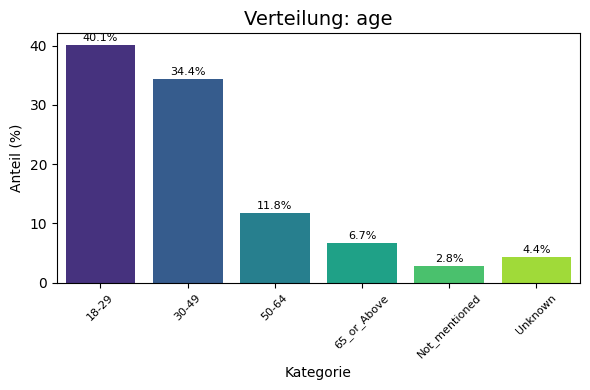

In [ ]:
# Verteilung einzelner Kategorie anzeigen:
plot_category_distribution(distribution_df, "age")   # Variables: age, edu, gender, income, politics, race, region, reli

In [ ]:
cleaned_dataset.tail(1)

,uid,word_count,temperature,max_tokens,model,backstory,age_18-29,age_30-49,age_50-64,age_65_or_Above,...,region_South,region_West,region_Not_mentioned,region_Unknown,politics_Republican,politics_Democrat,politics_Independent,politics_Other,politics_No_preference,politics_Unknown
11357,22536.0,321,1.0,128.0,meta-llama/Meta-Llama-3-70B,"At 25, I’m still a young man, and everything t...",1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.325,0.175,0.125,0.075,0.15,0.15


In [ ]:
# Configuration of demographics
np.random.seed(RANDOM_STATE)
def create_final_persona_column(df, variable_name, category_prefix):
    variable_columns = [col for col in df.columns if col.startswith(category_prefix)] # Select all relevant columns for the given variable
    probabilities = df[variable_columns].values  # Extract probabilities from the columns
    categories = [col.replace(category_prefix, "") for col in variable_columns] # Extract categories from the column names
    final_persona_values = []  # Ignore “Unknown” and normalize the probabilities for other categories
    for probs in probabilities:
        if "Unknown" in categories:
            unknown_idx = categories.index("Unknown") # Find and ignore index of “Unknown”
            probs = np.delete(probs, unknown_idx)  # Remove “Unknown” probability
            filtered_categories = [cat for idx, cat in enumerate(categories) if idx != unknown_idx]
        else:
            filtered_categories = categories
        if np.sum(probs) > 0: # Normalize the probabilities of the remaining categories
            norm_probs = probs / np.sum(probs)  # Normalize probabilities
            selected_category = np.random.choice(filtered_categories, p=norm_probs)
        else:
            selected_category = "Unknown"  # Default value if all probabilities are 0
        final_persona_values.append(selected_category)
    return pd.Series(final_persona_values, index=df.index, name=f"temp_{variable_name}")  # Return series object

In [ ]:
# Final assignment of each persona to a fixed category per variable
for variable_name, category_prefix in [("age", "age_"), ("edu", "edu_"), ("gender", "gender_"), ("income", "income_"), ("race", "race_"), ("reli", "reli_"), ("region", "region_"), ("politics", "politics_")]:
    cleaned_dataset[f"temp_{variable_name}"] = create_final_persona_column(cleaned_dataset, variable_name, category_prefix)

In [ ]:
cleaned_dataset.head(1)

,uid,word_count,temperature,max_tokens,model,backstory,age_18-29,age_30-49,age_50-64,age_65_or_Above,...,politics_No_preference,politics_Unknown,temp_age,temp_edu,temp_gender,temp_income,temp_race,temp_reli,temp_region,temp_politics
0,0.0,116,1.0,128.0,meta-llama/Meta-Llama-3-70B,"I was born in Austin in 1988, grew up in Hutto...",1.0,0.0,0.0,0.0,...,0.125,0.15,18-29,Associate_degree,Male,Not_mentioned,Hispanic_or_Latino_a,Prefer_not_to_answer,South,Democrat


In [ ]:
# Add a new column for Ethnicity (Hispanic / Not Hispanic) based on temp_race
cleaned_dataset['temp_ethni'] = cleaned_dataset['temp_race'].apply(lambda x: "Hispanic" if x == "Hispanic_or_Latino_a" else "Not Hispanic")
column_order = cleaned_dataset.columns.tolist()
column_order.insert(column_order.index('temp_race') + 1, column_order.pop(column_order.index('temp_ethni')))
cleaned_dataset = cleaned_dataset[column_order]
cleaned_dataset.head(2)

,uid,word_count,temperature,max_tokens,model,backstory,age_18-29,age_30-49,age_50-64,age_65_or_Above,...,politics_Unknown,temp_age,temp_edu,temp_gender,temp_income,temp_race,temp_ethni,temp_reli,temp_region,temp_politics
0,0.0,116,1.0,128.0,meta-llama/Meta-Llama-3-70B,"I was born in Austin in 1988, grew up in Hutto...",1.0,0.0,0.0,0.0,...,0.150,18-29,Associate_degree,Male,Not_mentioned,Hispanic_or_Latino_a,Hispanic,Prefer_not_to_answer,South,Democrat
1,1.0,313,1.0,128.0,meta-llama/Meta-Llama-3-70B,"I am in my late 30s, grew up in a small town i...",0.0,1.0,0.0,0.0,...,0.275,30-49,Bachelor's_degree,Male,"Less_than_USD10,000",Native_Hawaiian_or_Other_Pacific_Islander,Not Hispanic,Atheist,South,Democrat


In [ ]:
# Creation of the persona strings
def create_persona_strings(row):
    persona_full = "This is a brief description of your life: '" + row['backstory'] + ".' Furthermore, this is a brief demographic profile of you: "
    persona_dem = "This is a brief demographic profile of you: "
    demographic_variables = {
        "age": "Age",
        "edu": "Education",
        "gender": "Gender",
        "race": "Race",
        "ethni": "Ehnicity",
        "income": "Income",
        "reli": "Religion",
        "region": "Region",
        "politics": "Political affiliation"}
    demographics_full = []
    demographics_dem = []
    for variable, full_name in demographic_variables.items():
        attribute_text = f"{full_name}: {row[f'temp_{variable}']}"
        demographics_full.append(attribute_text)
        demographics_dem.append(attribute_text)
    persona_full += ", ".join(demographics_full)
    persona_dem += ", ".join(demographics_dem)
    return pd.Series([persona_full, persona_dem])

cleaned_dataset[["persona_full", "persona_dem"]] = cleaned_dataset.apply(create_persona_strings, axis=1)

In [ ]:
cleaned_dataset[["persona_full", "persona_dem"]].head(3)

,persona_full,persona_dem
0,This is a brief description of your life: 'I w...,This is a brief demographic profile of you: Ag...
1,This is a brief description of your life: 'I a...,This is a brief demographic profile of you: Ag...
2,"This is a brief description of your life: 'Ok,...",This is a brief demographic profile of you: Ag...


**D. Enrichring dataset via prompting**

In [ ]:
# LLM-API Setup
base_url = "https://gpt.uni-muenster.de/v1"
model = "Llama-3.3-70B"
client = OpenAI(api_key = API_KEY, base_url = base_url)

In [ ]:
# Create batches
batch_size = 1200
num_batches = 10
batches = [cleaned_dataset.iloc[i * batch_size: (i + 1) * batch_size].copy() for i in range(num_batches - 1)]
batches.append(cleaned_dataset.iloc[(num_batches - 1) * batch_size:].copy())  # Last batch contains the remaining personas

In [ ]:
# Questions and answer options for later mapping
question_map = {"1": ("temp_marriage", {"A": "Yes", "B": "No"}),
                "2": ("temp_employment", {"A": "Fulltime", "B": "Parttime", "C": "Self-employed", "D": "Laid off under 1 year", "E": "Laid off over 1 year", "F": "Unable to work", "G": "Student", "H": "Homemaker", "I": "Retired"}),
                "3": ("temp_wine_glasses", {"A": "0 glasses", "B": "1-3 glasses", "C": "4-7 glasses", "D": "8-10 glasses", "E": "more than 10 glasses"}),
                "4": ("temp_wine_price", {"A": "Less than $7.00", "B": "$7.00 to $9.99", "C": "$10.00 to $12.99", "D": "$13.00 to $16.99", "E": "$17.00 to $19.99", "F": "$20.00 to $25.99", "G": "$26.00 or more"}),
                "5": ("temp_us_state", {"A": "Yes", "B": "No"}),
                "6": ("temp_lawn", {"A": "Yes", "B": "No"}),
                "7": ("temp_fert_applied", {"A": "Yes", "B": "No"}),
                "8": ("temp_fert_purchased", {"A": "Yes", "B": "No"}),
                "9": ("temp_HH_income", {"A": "Less than $10,000", "B": "$10,000–14,999", "C": "$15,000–19,999", "D": "$20,000–24,999", "E": "$25,000–34,999", "F": "$35,000–49,999", "G": "$50,000–74,999", "H": "$75,000 or more"})}

In [ ]:
# Function for enrichment through LLM prompting, processing and storage of a single batch
def process_batch(batch_number):
    if batch_number < 1 or batch_number > num_batches:
        raise ValueError("Batch-Nummer muss zwischen 1 und 10 liegen.")
    batch_index = batch_number - 1  # Because lists start at 0
    batch = batches[batch_index].copy()  # Ensure that the original is not changed
    answers = []
    for index, row in batch.iterrows():
        persona_string = row["persona_full"]  # Take persona data from each line
        try:  # Inquiry to the LLM
            completion = client.chat.completions.create(
                messages=[
                    {"role": "system", "content": f"{persona_string}. Now imagine that you are that person and act as a survey participant. You are asked the following questions:"},
                    {"role": "user", "content": "1. Are you currently married? A. Yes B. No ; "
                                                "2. What is your current employment status? A. Fulltime, B. Parttime, C. Self-employed, D. Laid off under 1 year, E. Laid off over 1 year, F. Unable to work, G. Student, H. Homemaker, I. Retired ; "
                                                "3. How many glasses of wine do you drink per week? A. 0 glasses, B. 1-3 glasses, C. 4-7 glasses, D. 8-10 glasses, E. more than 10 glasses ; "
                                                "4. How much do you spend on average per bottle of wine? A. Less than $7.00, B. $7.00 to $9.99, C. $10.00 to $12.99, D. $13.00 to $16.99, E. $17.00 to $19.99, F. $20.00 to $25.99, G. $26.00 or more ; "
                                                "5. Do you live in one of the following U.S. states: Florida, Illinois, Maine, Maryland, Michigan, Minnesota, New Jersey, New York, Vermont, Virginia, Washington, or Wisconsin? A. Yes, B. No ; "
                                                "6. Does your home include a lawn? A. Yes, B. No ; "
                                                "7. Have you ever applied fertilizer on your lawn yourself? A. Yes, B. No ; "
                                                "8. Have you purchased lawn fertilizers in the past 12 months? A. Yes, B. No ; "
                                                "9. What is your annual household income? A. Less than $10,000, B. $10,000–14,999, C. $15,000–19,999, D. $20,000–24,999, E. $25,000–34,999, F. $35,000–49,999, G. $50,000–74,999, H. $75,000 or more ; "
                                                "In your role as a survey participant, now answer each question by only giving the number of the question and the letter of the answer in the following format: |1.R|2.S|3.T|4.U|5.V|6.W|7.X|8.Y|9.Z|. Do not explain your choice."}],
                model = model,
                temperature = 1.0,
                max_tokens = 30)
            answer_text = completion.choices[0].message.content.strip()  # Save answer
            answers.append(answer_text)
            time.sleep(0.5)  # If necessary to avoid rate limits of the API
        except Exception as e:
            print(f"Fehler bei Index {index}: {e}")
            answers.append(None)  # If error, save empty response
    batch["answer_enrichment"] = answers  # Insert answers into the batch
    for index, row in batch.iterrows():     # Loop through batch and convert LLM output into columns
        if pd.isna(row["answer_enrichment"]):
            continue
        responses = row["answer_enrichment"].strip("|").split("|")  # Clean up answer format “|1.B|2.C|3.A|...”
        for response in responses:
            try:
                question_num, answer_letter = response.split(".")
                question_num = question_num.strip()
                answer_letter = answer_letter.strip()
                if question_num in question_map:
                    column_name, answer_dict = question_map[question_num]
                    batch.at[index, column_name] = answer_dict.get(answer_letter, "Unknown")  # Convert answer to plain text
            except ValueError:
                print(f"Fehler beim Verarbeiten der Antwort: {response} (Index {index})")
                continue
    batch.to_csv(f"batch_{batch_number}_of_10.csv", index=False) # Save batch to CSV
    print(f"Batch {batch_number} verarbeitet und gespeichert als 'batch_{batch_number}_of_10.csv'")
    return batch

In [ ]:
# Function to extend Colab session
def keep_colab_alive(interval=60, duration=80):
    start_time = time.time()
    while (time.time() - start_time) < (duration * 60):
        print("Keep-Alive läuft...", flush=True)
        time.sleep(interval)

In [ ]:
keep_alive_thread = threading.Thread(target=keep_colab_alive, args=(60, 80), daemon=True)
keep_alive_thread.start()
batch_1_of_10 = process_batch(1)  # Processes batch 1

Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...


In [ ]:
# Batch 1 analysis
    # Runtime:                   22 min
    # Index with erros:          -
    # Answer processing errors:  594, 697
batch_1_of_10.to_csv("/content/drive/My Drive/batch_1_of_10.csv", index=False)
files.download("/content/drive/My Drive/batch_1_of_10.csv")
batch_1_of_10.tail(2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,uid,word_count,temperature,max_tokens,model,backstory,age_18-29,age_30-49,age_50-64,age_65_or_Above,...,answer_enrichment,temp_marriage,temp_employment,temp_wine_glasses,temp_wine_price,temp_us_state,temp_lawn,temp_fert_applied,temp_fert_purchased,temp_HH_income
1198,1200.0,135,1.0,128.0,meta-llama/Meta-Llama-3-70B,"I am from Taunton, MA. I grew up with two sist...",0.475,0.475,0.0,0.025,...,|1.B|2.A|3.B|4.C|5.B|6.A|7.B|8.B|9.B|,No,Fulltime,1-3 glasses,$10.00 to $12.99,No,Yes,No,No,"$10,000–14,999"
1199,1201.0,130,1.0,128.0,meta-llama/Meta-Llama-3-70B,"“I’m a 25-year-old boy from the United States,...",1.000,0.000,0.0,0.000,...,|1.B|2.A|3.B|4.F|5.A|6.B|7.B|8.B|9.H|,No,Fulltime,1-3 glasses,$20.00 to $25.99,Yes,No,No,No,"$75,000 or more"


In [ ]:
temp_columns = ["temp_marriage", "temp_employment", "temp_wine_glasses", "temp_wine_price", "temp_us_state", "temp_lawn", "temp_fert_applied", "temp_fert_purchased", "temp_HH_income"]
distribution_tables_batch_1_of_10 = {col: batch_1_of_10[col].value_counts().reset_index() for col in temp_columns}
distribution_batch_1_of_10 = pd.concat(distribution_tables_batch_1_of_10, axis=1)
distribution_batch_1_of_10

temp_marriage               temp_employment           temp_wine_glasses  \
  temp_marriage  count        temp_employment count     temp_wine_glasses   
0            No  916.0               Fulltime   539           1-3 glasses   
1           Yes  284.0                Student   255             0 glasses   
2           NaN    NaN          Self-employed   160           4-7 glasses   
3           NaN    NaN                Retired   108  more than 10 glasses   
4           NaN    NaN              Homemaker    71          8-10 glasses   
5           NaN    NaN               Parttime    39                   NaN   
6           NaN    NaN         Unable to work    23                   NaN   
7           NaN    NaN   Laid off over 1 year     3                   NaN   
8           NaN    NaN  Laid off under 1 year     2                   NaN   

           temp_wine_price        temp_us_state        temp_lawn         \
   count   temp_wine_price  count temp_us_state  count temp_lawn  count   
0  874.0  $10.00 to $12.99  368.0            No  732.0       Yes  782.0   
1  317.0   Less than $7.00  328.0           Yes  468.0        No  417.0   
2    5.0  $13.00 to $16.99  247.0           NaN    NaN   Unknown    1.0   
3    3.0  $20.00 to $25.99  202.0           NaN    NaN       NaN    NaN   
4    1.0    $7.00 to $9.99   31.0           NaN    NaN       NaN    NaN   
5    NaN    $26.00 or more   24.0           NaN    NaN       NaN    NaN   
6    NaN               NaN    NaN           NaN    NaN       NaN    NaN   
7    NaN               NaN    NaN           NaN    NaN       NaN    NaN   
8    NaN               NaN    NaN           NaN    NaN       NaN    NaN   

  temp_fert_applied        temp_fert_purchased            temp_HH_income  \
  temp_fert_applied  count temp_fert_purchased  count     temp_HH_income   
0                No  895.0                  No  891.0    $75,000 or more   
1               Yes  305.0                 Yes  307.0     $50,000–74,999   
2               NaN    NaN                 NaN    NaN  Less than $10,000   
3               NaN    NaN                 NaN    NaN     $35,000–49,999   
4               NaN    NaN                 NaN    NaN     $10,000–14,999   
5               NaN    NaN                 NaN    NaN     $20,000–24,999   
6               NaN    NaN                 NaN    NaN     $25,000–34,999   
7               NaN    NaN                 NaN    NaN     $15,000–19,999   
8               NaN    NaN                 NaN    NaN                NaN   

          
   count  
0  426.0  
1  194.0  
2  143.0  
3  122.0  
4  112.0  
5  109.0  
6   82.0  
7   10.0  
8    NaN

In [ ]:
keep_alive_thread = threading.Thread(target=keep_colab_alive, args=(60, 80), daemon=True)
keep_alive_thread.start()
batch_2_of_10 = process_batch(2)  # Processes batch 2

Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Fehler bei Index 1718: <!DOCTYPE html>
<html lang="de">

<head>
    <meta charset="utf-8" />
    <meta http-equiv="Content-Security-Policy" content="default-src: https: data: 'unsafe-inline' 'unsafe-eval';" />
    <title>Service Unavailable</title>
    <link rel="shortcut icon"
        href="https://www.uni-muenster.de/imperia/md/content/allgemein/farbunabhaengig/favicon.ico" />
    <style type="text/css">
        html {
            font-size: 1.1em;
            line-height: 

In [ ]:
file_path = "/content/batch_2_of_10.csv"  # Falls sie woanders ist, Pfad anpassen
batch_2_of_10 = pd.read_csv(file_path)
batch_2_of_10.head()

,uid,word_count,temperature,max_tokens,model,backstory,age_18-29,age_30-49,age_50-64,age_65_or_Above,...,answer_enrichment,temp_marriage,temp_employment,temp_wine_glasses,temp_wine_price,temp_us_state,temp_lawn,temp_fert_applied,temp_fert_purchased,temp_HH_income
0,1202.0,144,1.0,128.0,meta-llama/Meta-Llama-3-70B,"I am a 24-year-old junior from Winthrop, South...",1.000,0.000,0.00,0.000,...,|1.B|2.G|3.A|4.A|5.B|6.A|7.B|8.B|9.A|,No,Student,0 glasses,Less than $7.00,No,Yes,No,No,"Less than $10,000"
1,1203.0,136,1.0,128.0,meta-llama/Meta-Llama-3-70B,Everything matters. Each memory and each event...,0.325,0.275,0.15,0.075,...,|1.B|2.G|3.B|4.A|5.A|6.A|7.B|8.B|9.A|,No,Student,1-3 glasses,Less than $7.00,Yes,Yes,No,No,"Less than $10,000"
2,1204.0,144,1.0,128.0,meta-llama/Meta-Llama-3-70B,"Hey, this is a big question and it comes up a ...",0.000,1.000,0.00,0.000,...,|1.B|2.A|3.B|4.D|5.A|6.A|7.A|8.A|9.H|,No,Fulltime,1-3 glasses,$13.00 to $16.99,Yes,Yes,Yes,Yes,"$75,000 or more"
3,1205.0,134,1.0,128.0,meta-llama/Meta-Llama-3-70B,I am the manager of Corrosion Control. I was b...,0.225,0.350,0.20,0.100,...,|1.A|2.A|3.B|4.F|5.B|6.A|7.A|8.A|9.H|,Yes,Fulltime,1-3 glasses,$20.00 to $25.99,No,Yes,Yes,Yes,"$75,000 or more"
4,1206.0,134,1.0,128.0,meta-llama/Meta-Llama-3-70B,Let me tell you about myself. I was born on 20...,0.000,1.000,0.00,0.000,...,|1.B|2.A|3.B|4.C|5.B|6.B|7.B|8.B|9.G|,No,Fulltime,1-3 glasses,$10.00 to $12.99,No,No,No,No,"$50,000–74,999"


Keep-Alive läuft...


In [ ]:
# Batch 2 analysis
    # Runtime:                    1 hour
    # Index with erros:           1718-1723
    # Answer processing errors:   2122
temp_columns = ["temp_marriage", "temp_employment", "temp_wine_glasses", "temp_wine_price", "temp_us_state", "temp_lawn", "temp_fert_applied", "temp_fert_purchased", "temp_HH_income"]
distribution_tables_batch_2_of_10 = {col: batch_2_of_10[col].value_counts().reset_index() for col in temp_columns}
distribution_batch_2_of_10 = pd.concat(distribution_tables_batch_2_of_10, axis=1)
distribution_batch_2_of_10

temp_marriage               temp_employment           temp_wine_glasses  \
  temp_marriage  count        temp_employment count     temp_wine_glasses   
0            No  947.0               Fulltime   431           1-3 glasses   
1           Yes  246.0                Student   294             0 glasses   
2           NaN    NaN          Self-employed   187  more than 10 glasses   
3           NaN    NaN                Retired   155           4-7 glasses   
4           NaN    NaN              Homemaker    48          8-10 glasses   
5           NaN    NaN               Parttime    41                   NaN   
6           NaN    NaN         Unable to work    24                   NaN   
7           NaN    NaN   Laid off over 1 year     9                   NaN   
8           NaN    NaN  Laid off under 1 year     4                   NaN   

           temp_wine_price        temp_us_state        temp_lawn         \
   count   temp_wine_price  count temp_us_state  count temp_lawn  count   
0  766.0   Less than $7.00  427.0            No  750.0       Yes  772.0   
1  415.0  $10.00 to $12.99  341.0           Yes  443.0        No  420.0   
2    7.0  $13.00 to $16.99  194.0           NaN    NaN   Unknown    1.0   
3    3.0  $20.00 to $25.99  183.0           NaN    NaN       NaN    NaN   
4    2.0    $26.00 or more   36.0           NaN    NaN       NaN    NaN   
5    NaN    $7.00 to $9.99   12.0           NaN    NaN       NaN    NaN   
6    NaN               NaN    NaN           NaN    NaN       NaN    NaN   
7    NaN               NaN    NaN           NaN    NaN       NaN    NaN   
8    NaN               NaN    NaN           NaN    NaN       NaN    NaN   

  temp_fert_applied        temp_fert_purchased            temp_HH_income  \
  temp_fert_applied  count temp_fert_purchased  count     temp_HH_income   
0                No  834.0                  No  831.0    $75,000 or more   
1               Yes  359.0                 Yes  361.0  Less than $10,000   
2               NaN    NaN                 NaN    NaN     $50,000–74,999   
3               NaN    NaN                 NaN    NaN     $35,000–49,999   
4               NaN    NaN                 NaN    NaN     $10,000–14,999   
5               NaN    NaN                 NaN    NaN     $20,000–24,999   
6               NaN    NaN                 NaN    NaN     $25,000–34,999   
7               NaN    NaN                 NaN    NaN     $15,000–19,999   
8               NaN    NaN                 NaN    NaN                NaN   

          
   count  
0  413.0  
1  178.0  
2  164.0  
3  114.0  
4  114.0  
5  108.0  
6   86.0  
7   15.0  
8    NaN

In [ ]:
keep_alive_thread = threading.Thread(target=keep_colab_alive, args=(60, 80), daemon=True)
keep_alive_thread.start()
batch_3_of_10 = process_batch(3)  # Processes batch 3

Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...


In [ ]:
file_path = "/content/batch_3_of_10.csv"  # Falls sie woanders ist, Pfad anpassen
batch_3_of_10 = pd.read_csv(file_path)
batch_3_of_10.head()

,uid,word_count,temperature,max_tokens,model,backstory,age_18-29,age_30-49,age_50-64,age_65_or_Above,...,answer_enrichment,temp_marriage,temp_employment,temp_wine_glasses,temp_wine_price,temp_us_state,temp_lawn,temp_fert_applied,temp_fert_purchased,temp_HH_income
0,2402.0,708,1.0,128.0,meta-llama/Meta-Llama-3-70B,"I’ve always loved drawing. I had a… well, stil...",0.45,0.30,0.100,0.050,...,|1.B|2.C|3.B|4.F|5.B|6.B|7.B|8.B|9.G|,No,Self-employed,1-3 glasses,$20.00 to $25.99,No,No,No,No,"$50,000–74,999"
1,2403.0,144,1.0,128.0,meta-llama/Meta-Llama-3-70B,I’m a 21 year old male college student in Phoe...,1.00,0.00,0.000,0.000,...,|1.B|2.G|3.A|4.A|5.B|6.A|7.B|8.B|9.H|,No,Student,0 glasses,Less than $7.00,No,Yes,No,No,"$75,000 or more"
2,2404.0,171,1.0,128.0,meta-llama/Meta-Llama-3-70B,My name is Khan Ha Ha. I’m 27 years old and I’...,1.00,0.00,0.000,0.000,...,|1.B|2.H|3.A|4.A|5.A|6.A|7.B|8.B|9.D|,No,Homemaker,0 glasses,Less than $7.00,Yes,Yes,No,No,"$20,000–24,999"
3,2405.0,235,1.0,128.0,meta-llama/Meta-Llama-3-70B,Umm… I guess… I grew up in New Jersey. There I...,0.20,0.15,0.175,0.175,...,|1.B|2.C|3.B|4.D|5.A|6.A|7.B|8.B|9.G|,No,Self-employed,1-3 glasses,$13.00 to $16.99,Yes,Yes,No,No,"$50,000–74,999"
4,2406.0,1139,1.0,128.0,meta-llama/Meta-Llama-3-70B,"Over 70 years ago, when I was about 8 years ol...",0.00,0.00,0.000,1.000,...,|1.B|2.I|3.A|4.A|5.B|6.A|7.B|8.B|9.H|,No,Retired,0 glasses,Less than $7.00,No,Yes,No,No,"$75,000 or more"


In [ ]:
# Batch 3 analysis
    # Runtime:                    1 hour
    # Index with erros:
    # Answer processing errors:
temp_columns = ["temp_marriage", "temp_employment", "temp_wine_glasses", "temp_wine_price", "temp_us_state", "temp_lawn", "temp_fert_applied", "temp_fert_purchased", "temp_HH_income"]
distribution_tables_batch_3_of_10 = {col: batch_3_of_10[col].value_counts().reset_index() for col in temp_columns}
distribution_batch_3_of_10 = pd.concat(distribution_tables_batch_3_of_10, axis=1)
distribution_batch_3_of_10

temp_marriage               temp_employment           temp_wine_glasses  \
  temp_marriage  count        temp_employment count     temp_wine_glasses   
0            No  955.0               Fulltime   451           1-3 glasses   
1           Yes  245.0                Student   314             0 glasses   
2           NaN    NaN                Retired   144  more than 10 glasses   
3           NaN    NaN          Self-employed   141           4-7 glasses   
4           NaN    NaN              Homemaker    53                   NaN   
5           NaN    NaN               Parttime    53                   NaN   
6           NaN    NaN         Unable to work    31                   NaN   
7           NaN    NaN   Laid off over 1 year     7                   NaN   
8           NaN    NaN  Laid off under 1 year     6                   NaN   

           temp_wine_price        temp_us_state        temp_lawn         \
   count   temp_wine_price  count temp_us_state  count temp_lawn  count   
0  705.0   Less than $7.00  478.0            No  748.0       Yes  755.0   
1  485.0  $10.00 to $12.99  287.0           Yes  452.0        No  444.0   
2    7.0  $13.00 to $16.99  212.0           NaN    NaN   Unknown    1.0   
3    3.0  $20.00 to $25.99  170.0           NaN    NaN       NaN    NaN   
4    NaN    $26.00 or more   29.0           NaN    NaN       NaN    NaN   
5    NaN    $7.00 to $9.99   24.0           NaN    NaN       NaN    NaN   
6    NaN               NaN    NaN           NaN    NaN       NaN    NaN   
7    NaN               NaN    NaN           NaN    NaN       NaN    NaN   
8    NaN               NaN    NaN           NaN    NaN       NaN    NaN   

  temp_fert_applied        temp_fert_purchased            temp_HH_income  \
  temp_fert_applied  count temp_fert_purchased  count     temp_HH_income   
0                No  885.0                  No  884.0    $75,000 or more   
1               Yes  314.0                 Yes  315.0     $50,000–74,999   
2           Unknown    1.0             Unknown    1.0  Less than $10,000   
3               NaN    NaN                 NaN    NaN     $35,000–49,999   
4               NaN    NaN                 NaN    NaN     $10,000–14,999   
5               NaN    NaN                 NaN    NaN     $20,000–24,999   
6               NaN    NaN                 NaN    NaN     $25,000–34,999   
7               NaN    NaN                 NaN    NaN     $15,000–19,999   
8               NaN    NaN                 NaN    NaN                NaN   

          
   count  
0  406.0  
1  195.0  
2  170.0  
3  114.0  
4  111.0  
5  107.0  
6   81.0  
7   16.0  
8    NaN

In [ ]:
keep_alive_thread = threading.Thread(target=keep_colab_alive, args=(60, 80), daemon=True)
keep_alive_thread.start()
batch_4_of_10 = process_batch(4)  # Processes batch 4

Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Fehler bei Index 3983: <!DOCTYPE html>
<html lang="de">

<head>
    <meta charset="utf-8" />
    <meta http-equiv="Content-Security-Policy" content="default-src: https: data: 'unsafe-inline' 'unsafe-eval';" />
    <title>Service Unavailable</title>
    <link rel="shortcut icon"
        href="https://www.uni-muenster.de/imperia/md/content/allgemein/farbunabha

In [ ]:
file_path = "/content/batch_4_of_10.csv"
batch_4_of_10 = pd.read_csv(file_path)
batch_4_of_10.head(1)

,uid,word_count,temperature,max_tokens,model,backstory,age_18-29,age_30-49,age_50-64,age_65_or_Above,...,answer_enrichment,temp_marriage,temp_employment,temp_wine_glasses,temp_wine_price,temp_us_state,temp_lawn,temp_fert_applied,temp_fert_purchased,temp_HH_income
0,3602.0,163,1.0,128.0,meta-llama/Meta-Llama-3-70B,"For the first question, I am 16 years old. I g...",0.325,0.2,0.175,0.125,...,|1.B|2.G|3.A|4.A|5.B|6.B|7.B|8.B|9.H|,No,Student,0 glasses,Less than $7.00,No,No,No,No,"$75,000 or more"


In [ ]:
# Batch 4 analysis
    # Runtime:                    1 hourm 2 ninutes
    # Index with erros:           3983 - 3990,
    # Answer processing errors:   3628, 4032, 4138, 4698
temp_columns = ["temp_marriage", "temp_employment", "temp_wine_glasses", "temp_wine_price", "temp_us_state", "temp_lawn", "temp_fert_applied", "temp_fert_purchased", "temp_HH_income"]
distribution_tables_batch_4_of_10 = {col: batch_4_of_10[col].value_counts().reset_index() for col in temp_columns}
distribution_batch_4_of_10 = pd.concat(distribution_tables_batch_4_of_10, axis=1)
distribution_batch_4_of_10

temp_marriage               temp_employment           temp_wine_glasses  \
  temp_marriage  count        temp_employment count     temp_wine_glasses   
0            No  932.0               Fulltime   455           1-3 glasses   
1           Yes  259.0                Student   291             0 glasses   
2           NaN    NaN          Self-employed   162  more than 10 glasses   
3           NaN    NaN                Retired   126           4-7 glasses   
4           NaN    NaN              Homemaker    58          8-10 glasses   
5           NaN    NaN         Unable to work    44                   NaN   
6           NaN    NaN               Parttime    43                   NaN   
7           NaN    NaN  Laid off under 1 year     9                   NaN   
8           NaN    NaN   Laid off over 1 year     3                   NaN   

           temp_wine_price        temp_us_state        temp_lawn         \
   count   temp_wine_price  count temp_us_state  count temp_lawn  count   
0  708.0   Less than $7.00  467.0            No  792.0       Yes  745.0   
1  472.0  $10.00 to $12.99  306.0           Yes  399.0        No  446.0   
2    6.0  $13.00 to $16.99  198.0           NaN    NaN       NaN    NaN   
3    3.0  $20.00 to $25.99  163.0           NaN    NaN       NaN    NaN   
4    2.0    $26.00 or more   45.0           NaN    NaN       NaN    NaN   
5    NaN    $7.00 to $9.99   11.0           NaN    NaN       NaN    NaN   
6    NaN  $17.00 to $19.99    1.0           NaN    NaN       NaN    NaN   
7    NaN               NaN    NaN           NaN    NaN       NaN    NaN   
8    NaN               NaN    NaN           NaN    NaN       NaN    NaN   

  temp_fert_applied        temp_fert_purchased            temp_HH_income  \
  temp_fert_applied  count temp_fert_purchased  count     temp_HH_income   
0                No  849.0                  No  846.0    $75,000 or more   
1               Yes  342.0                 Yes  341.0     $50,000–74,999   
2               NaN    NaN                 NaN    NaN  Less than $10,000   
3               NaN    NaN                 NaN    NaN     $35,000–49,999   
4               NaN    NaN                 NaN    NaN     $10,000–14,999   
5               NaN    NaN                 NaN    NaN     $20,000–24,999   
6               NaN    NaN                 NaN    NaN     $25,000–34,999   
7               NaN    NaN                 NaN    NaN     $15,000–19,999   
8               NaN    NaN                 NaN    NaN                NaN   

          
   count  
0  395.0  
1  185.0  
2  178.0  
3  128.0  
4  122.0  
5   92.0  
6   65.0  
7   22.0  
8    NaN

In [ ]:
keep_alive_thread = threading.Thread(target=keep_colab_alive, args=(60, 80), daemon=True)
keep_alive_thread.start()
batch_5_of_10 = process_batch(5)

Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Fehler bei Index 4898: <!DOCTYPE html>
<html lang="de">

<head>
    <meta charset="utf-8" />
    <meta http-equiv="Content-Security-Policy" content="default-src: https: data: 'unsafe-inline' 'unsafe-eval';" />
    <title>Service Unavailable</title>
    <link rel="shortcut icon"
        href="https://www.uni-muenster.de/imperia/md/content/allgemein/farbunabhaengig/favicon.ico" />
    <style type="text/css">
        html {
            font-size: 1.1em;
            line-height: 1.4;
            font-family: Calibri, Carlito, Verdana, sans-serif;
        }

        body {
     

In [ ]:
file_path = "/content/batch_5_of_10.csv"
batch_5_of_10 = pd.read_csv(file_path)
batch_5_of_10.head(1)

,uid,word_count,temperature,max_tokens,model,backstory,age_18-29,age_30-49,age_50-64,age_65_or_Above,...,answer_enrichment,temp_marriage,temp_employment,temp_wine_glasses,temp_wine_price,temp_us_state,temp_lawn,temp_fert_applied,temp_fert_purchased,temp_HH_income
0,10090.0,393,1.0,128.0,meta-llama/Meta-Llama-3-70B,I was born in a rural Pennsylvania town and li...,0.1,0.2,0.375,0.2,...,|1.B|2.A|3.A|4.A|5.B|6.B|7.B|8.B|9.A|,No,Fulltime,0 glasses,Less than $7.00,No,No,No,No,"Less than $10,000"


In [ ]:
# Batch 5 analysis
    # Runtime:                    1 hour, 13 minutes
    # Index with erros:           4898-4905, 5464-5472
    # Answer processing errors:   .
temp_columns = ["temp_marriage", "temp_employment", "temp_wine_glasses", "temp_wine_price", "temp_us_state", "temp_lawn", "temp_fert_applied", "temp_fert_purchased", "temp_HH_income"]
distribution_tables_batch_5_of_10 = {col: batch_5_of_10[col].value_counts().reset_index() for col in temp_columns}
distribution_batch_5_of_10 = pd.concat(distribution_tables_batch_5_of_10, axis=1)
distribution_batch_5_of_10

temp_marriage               temp_employment           temp_wine_glasses  \
  temp_marriage  count        temp_employment count     temp_wine_glasses   
0            No  988.0               Fulltime   497           1-3 glasses   
1           Yes  195.0                Student   287             0 glasses   
2           NaN    NaN          Self-employed   147  more than 10 glasses   
3           NaN    NaN                Retired   110           4-7 glasses   
4           NaN    NaN               Parttime    51          8-10 glasses   
5           NaN    NaN              Homemaker    46                   NaN   
6           NaN    NaN         Unable to work    30                   NaN   
7           NaN    NaN  Laid off under 1 year    10                   NaN   
8           NaN    NaN   Laid off over 1 year     5                   NaN   

           temp_wine_price        temp_us_state        temp_lawn         \
   count   temp_wine_price  count temp_us_state  count temp_lawn  count   
0  718.0   Less than $7.00  442.0            No  752.0       Yes  744.0   
1  458.0  $10.00 to $12.99  294.0           Yes  431.0        No  439.0   
2    4.0  $13.00 to $16.99  218.0           NaN    NaN       NaN    NaN   
3    2.0  $20.00 to $25.99  175.0           NaN    NaN       NaN    NaN   
4    1.0    $26.00 or more   33.0           NaN    NaN       NaN    NaN   
5    NaN    $7.00 to $9.99   20.0           NaN    NaN       NaN    NaN   
6    NaN  $17.00 to $19.99    1.0           NaN    NaN       NaN    NaN   
7    NaN               NaN    NaN           NaN    NaN       NaN    NaN   
8    NaN               NaN    NaN           NaN    NaN       NaN    NaN   

  temp_fert_applied        temp_fert_purchased            temp_HH_income  \
  temp_fert_applied  count temp_fert_purchased  count     temp_HH_income   
0                No  875.0                  No  875.0    $75,000 or more   
1               Yes  308.0                 Yes  308.0     $50,000–74,999   
2               NaN    NaN                 NaN    NaN  Less than $10,000   
3               NaN    NaN                 NaN    NaN     $10,000–14,999   
4               NaN    NaN                 NaN    NaN     $20,000–24,999   
5               NaN    NaN                 NaN    NaN     $35,000–49,999   
6               NaN    NaN                 NaN    NaN     $25,000–34,999   
7               NaN    NaN                 NaN    NaN     $15,000–19,999   
8               NaN    NaN                 NaN    NaN                NaN   

          
   count  
0  405.0  
1  184.0  
2  143.0  
3  130.0  
4  117.0  
5  117.0  
6   77.0  
7   10.0  
8    NaN

In [ ]:
keep_alive_thread = threading.Thread(target=keep_colab_alive, args=(60, 80), daemon=True)
keep_alive_thread.start()
batch_6_of_10 = process_batch(6)

Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...


In [ ]:
file_path = "/content/batch_6_of_10.csv"
batch_6_of_10 = pd.read_csv(file_path)
batch_6_of_10.head(1)

,uid,word_count,temperature,max_tokens,model,backstory,age_18-29,age_30-49,age_50-64,age_65_or_Above,...,answer_enrichment,temp_marriage,temp_employment,temp_wine_glasses,temp_wine_price,temp_us_state,temp_lawn,temp_fert_applied,temp_fert_purchased,temp_HH_income
0,11290.0,265,1.0,128.0,meta-llama/Meta-Llama-3-70B,"Hi, I’m Lara, I’m 24 years old, and I was born...",1.0,0.0,0.0,0.0,...,|1.B|2.G|3.B|4.C|5.B|6.A|7.B|8.B|9.F|,No,Student,1-3 glasses,$10.00 to $12.99,No,Yes,No,No,"$35,000–49,999"


In [ ]:
# Batch 6 analysis
    # Runtime:                    .
    # Index with erros:           6779-6785 , 6839-6846, 6950-6954
    # Answer processing errors:   6626
temp_columns = ["temp_marriage", "temp_employment", "temp_wine_glasses", "temp_wine_price", "temp_us_state", "temp_lawn", "temp_fert_applied", "temp_fert_purchased", "temp_HH_income"]
distribution_tables_batch_6_of_10 = {col: batch_6_of_10[col].value_counts().reset_index() for col in temp_columns}
distribution_batch_6_of_10 = pd.concat(distribution_tables_batch_6_of_10, axis=1)
distribution_batch_6_of_10

temp_marriage               temp_employment           temp_wine_glasses  \
  temp_marriage  count        temp_employment count     temp_wine_glasses   
0            No  979.0               Fulltime   480           1-3 glasses   
1           Yes  201.0                Student   303             0 glasses   
2           NaN    NaN          Self-employed   141           4-7 glasses   
3           NaN    NaN                Retired   104  more than 10 glasses   
4           NaN    NaN               Parttime    65                   NaN   
5           NaN    NaN         Unable to work    36                   NaN   
6           NaN    NaN              Homemaker    34                   NaN   
7           NaN    NaN  Laid off under 1 year    14                   NaN   
8           NaN    NaN   Laid off over 1 year     3                   NaN   

           temp_wine_price        temp_us_state        temp_lawn         \
   count   temp_wine_price  count temp_us_state  count temp_lawn  count   
0  718.0   Less than $7.00  462.0            No  732.0       Yes  772.0   
1  452.0  $10.00 to $12.99  290.0           Yes  448.0        No  408.0   
2    7.0  $13.00 to $16.99  205.0           NaN    NaN       NaN    NaN   
3    3.0  $20.00 to $25.99  183.0           NaN    NaN       NaN    NaN   
4    NaN    $26.00 or more   27.0           NaN    NaN       NaN    NaN   
5    NaN    $7.00 to $9.99   13.0           NaN    NaN       NaN    NaN   
6    NaN               NaN    NaN           NaN    NaN       NaN    NaN   
7    NaN               NaN    NaN           NaN    NaN       NaN    NaN   
8    NaN               NaN    NaN           NaN    NaN       NaN    NaN   

  temp_fert_applied        temp_fert_purchased            temp_HH_income  \
  temp_fert_applied  count temp_fert_purchased  count     temp_HH_income   
0                No  855.0                  No  855.0    $75,000 or more   
1               Yes  325.0                 Yes  324.0     $50,000–74,999   
2               NaN    NaN                 NaN    NaN  Less than $10,000   
3               NaN    NaN                 NaN    NaN     $10,000–14,999   
4               NaN    NaN                 NaN    NaN     $35,000–49,999   
5               NaN    NaN                 NaN    NaN     $20,000–24,999   
6               NaN    NaN                 NaN    NaN     $25,000–34,999   
7               NaN    NaN                 NaN    NaN     $15,000–19,999   
8               NaN    NaN                 NaN    NaN                NaN   

          
   count  
0  396.0  
1  193.0  
2  152.0  
3  137.0  
4  114.0  
5   96.0  
6   83.0  
7    8.0  
8    NaN

In [ ]:
keep_alive_thread = threading.Thread(target=keep_colab_alive, args=(60, 80), daemon=True)
keep_alive_thread.start()
batch_7_of_10 = process_batch(7)

Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Fehler bei Index 7413: <!DOCTYPE html>
<html lang="de">

<head>
    <meta charset="utf-8" />
    <meta http-equiv="Content-Security-Policy" content="default-src: https: data: 'unsafe-inline' 'unsafe-eval';" />
    <title>Service Unavailable</title>
    <link rel="shortcut icon"
        href="https://www.uni-muenster.de/imperia/md/content/allgemein/farbunabhaengig/favicon.ico" />
    <style type="text/css">
        html {
            font-size: 1.1em;
            line-height: 1.4;
            font-family: Calibri, Carlito, Verdana, sans-serif;
        }

        body {
            margin: 0;
        }

        header {
            margin: 1rem 1rem 2rem 1rem;
            border-bottom: 4px solid rgb(66, 60, 57);

In [ ]:
file_path = "/content/batch_7_of_10.csv"
batch_7_of_10 = pd.read_csv(file_path)
batch_7_of_10.head(1)

,uid,word_count,temperature,max_tokens,model,backstory,age_18-29,age_30-49,age_50-64,age_65_or_Above,...,answer_enrichment,temp_marriage,temp_employment,temp_wine_glasses,temp_wine_price,temp_us_state,temp_lawn,temp_fert_applied,temp_fert_purchased,temp_HH_income
0,12491.0,569,1.0,128.0,meta-llama/Meta-Llama-3-70B,(This is subjective to the individual so I wil...,0.275,0.325,0.125,0.175,...,|1.B|2.C|3.B|4.F|5.A|6.A|7.B|8.B|9.H|,No,Self-employed,1-3 glasses,$20.00 to $25.99,Yes,Yes,No,No,"$75,000 or more"


In [ ]:
# Batch 7 analysis
    # Runtime:                    1 hour, 13 min
    # Index with erros:           7413-7419, 7438-7439, 8088-8096, 8324-8328
    # Answer processing errors:   7397
temp_columns = ["temp_marriage", "temp_employment", "temp_wine_glasses", "temp_wine_price", "temp_us_state", "temp_lawn", "temp_fert_applied", "temp_fert_purchased", "temp_HH_income"]
distribution_tables_batch_7_of_10 = {col: batch_7_of_10[col].value_counts().reset_index() for col in temp_columns}
distribution_batch_7_of_10 = pd.concat(distribution_tables_batch_7_of_10, axis=1)
distribution_batch_7_of_10

temp_marriage               temp_employment           temp_wine_glasses  \
  temp_marriage  count        temp_employment count     temp_wine_glasses   
0            No  963.0               Fulltime   468           1-3 glasses   
1           Yes  214.0                Student   322             0 glasses   
2           NaN    NaN          Self-employed   130  more than 10 glasses   
3           NaN    NaN                Retired   111           4-7 glasses   
4           NaN    NaN               Parttime    53                   NaN   
5           NaN    NaN              Homemaker    52                   NaN   
6           NaN    NaN         Unable to work    27                   NaN   
7           NaN    NaN  Laid off under 1 year    11                   NaN   
8           NaN    NaN   Laid off over 1 year     3                   NaN   

           temp_wine_price        temp_us_state        temp_lawn         \
   count   temp_wine_price  count temp_us_state  count temp_lawn  count   
0  696.0   Less than $7.00  463.0            No  763.0       Yes  751.0   
1  472.0  $10.00 to $12.99  311.0           Yes  414.0        No  426.0   
2    5.0  $13.00 to $16.99  189.0           NaN    NaN       NaN    NaN   
3    4.0  $20.00 to $25.99  161.0           NaN    NaN       NaN    NaN   
4    NaN    $26.00 or more   35.0           NaN    NaN       NaN    NaN   
5    NaN    $7.00 to $9.99   16.0           NaN    NaN       NaN    NaN   
6    NaN  $17.00 to $19.99    2.0           NaN    NaN       NaN    NaN   
7    NaN               NaN    NaN           NaN    NaN       NaN    NaN   
8    NaN               NaN    NaN           NaN    NaN       NaN    NaN   

  temp_fert_applied        temp_fert_purchased            temp_HH_income  \
  temp_fert_applied  count temp_fert_purchased  count     temp_HH_income   
0                No  891.0                  No  889.0    $75,000 or more   
1               Yes  286.0                 Yes  287.0  Less than $10,000   
2               NaN    NaN                 NaN    NaN     $50,000–74,999   
3               NaN    NaN                 NaN    NaN     $10,000–14,999   
4               NaN    NaN                 NaN    NaN     $35,000–49,999   
5               NaN    NaN                 NaN    NaN     $20,000–24,999   
6               NaN    NaN                 NaN    NaN     $25,000–34,999   
7               NaN    NaN                 NaN    NaN     $15,000–19,999   
8               NaN    NaN                 NaN    NaN                NaN   

          
   count  
0  413.0  
1  161.0  
2  161.0  
3  122.0  
4  116.0  
5  108.0  
6   86.0  
7    9.0  
8    NaN

In [ ]:
keep_alive_thread = threading.Thread(target=keep_colab_alive, args=(60, 80), daemon=True)
keep_alive_thread.start()
batch_8_of_10 = process_batch(8)

Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Fehler bei Index 8520: Error code: 500 - {'error': {'message': 'litellm.APIError: HuggingfaceException - All connection attempts failed\nReceived Model Group=Llama-3.3-70B\nAvailable Model Group Fallbacks=None', 'type': None, 'param': None, 'code': '500'}}
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Fehler bei Index 8531: Error code: 500 - {'error': {'message': 'litellm.APIError: HuggingfaceException - All connection attempts failed\nReceived Model Group=Llama-3.3-70B\nAvailable Model Group Fallbacks=None', 'type': None, 'param': None, 'code': '500'}}
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-A

In [ ]:
file_path = "/content/batch_8_of_10.csv"
batch_8_of_10 = pd.read_csv(file_path)
batch_8_of_10.head(1)

,uid,word_count,temperature,max_tokens,model,backstory,age_18-29,age_30-49,age_50-64,age_65_or_Above,...,answer_enrichment,temp_marriage,temp_employment,temp_wine_glasses,temp_wine_price,temp_us_state,temp_lawn,temp_fert_applied,temp_fert_purchased,temp_HH_income
0,13693.0,251,1.0,128.0,meta-llama/Meta-Llama-3-70B,I am 26 years old and I grew up in a suburb of...,1.0,0.0,0.0,0.0,...,|1.B|2.A|3.C|4.F|5.B|6.B|7.B|8.B|9.D|,No,Fulltime,4-7 glasses,$20.00 to $25.99,No,No,No,No,"$20,000–24,999"


In [ ]:
# Batch 8 analysis
    # Runtime:                    1 hour, 14 min
    # Index with erros:           8520, 8531, 8940-8948
    # Answer processing errors:   -
temp_columns = ["temp_marriage", "temp_employment", "temp_wine_glasses", "temp_wine_price", "temp_us_state", "temp_lawn", "temp_fert_applied", "temp_fert_purchased", "temp_HH_income"]
distribution_tables_batch_8_of_10 = {col: batch_8_of_10[col].value_counts().reset_index() for col in temp_columns}
distribution_batch_8_of_10 = pd.concat(distribution_tables_batch_8_of_10, axis=1)
distribution_batch_8_of_10

temp_marriage               temp_employment           temp_wine_glasses  \
  temp_marriage  count        temp_employment count     temp_wine_glasses   
0            No  992.0               Fulltime   444           1-3 glasses   
1           Yes  197.0                Student   332             0 glasses   
2           NaN    NaN          Self-employed   163           4-7 glasses   
3           NaN    NaN                Retired    99  more than 10 glasses   
4           NaN    NaN               Parttime    64          8-10 glasses   
5           NaN    NaN              Homemaker    51                   NaN   
6           NaN    NaN         Unable to work    29                   NaN   
7           NaN    NaN  Laid off under 1 year     6                   NaN   
8           NaN    NaN   Laid off over 1 year     1                   NaN   

           temp_wine_price        temp_us_state        temp_lawn         \
   count   temp_wine_price  count temp_us_state  count temp_lawn  count   
0  704.0   Less than $7.00  472.0            No  787.0       Yes  712.0   
1  478.0  $10.00 to $12.99  315.0           Yes  402.0        No  477.0   
2    5.0  $13.00 to $16.99  204.0           NaN    NaN       NaN    NaN   
3    1.0  $20.00 to $25.99  150.0           NaN    NaN       NaN    NaN   
4    1.0    $26.00 or more   30.0           NaN    NaN       NaN    NaN   
5    NaN    $7.00 to $9.99   18.0           NaN    NaN       NaN    NaN   
6    NaN               NaN    NaN           NaN    NaN       NaN    NaN   
7    NaN               NaN    NaN           NaN    NaN       NaN    NaN   
8    NaN               NaN    NaN           NaN    NaN       NaN    NaN   

  temp_fert_applied        temp_fert_purchased            temp_HH_income        
  temp_fert_applied  count temp_fert_purchased  count     temp_HH_income count  
0                No  910.0                  No  907.0    $75,000 or more   376  
1               Yes  279.0                 Yes  282.0  Less than $10,000   172  
2               NaN    NaN                 NaN    NaN     $50,000–74,999   168  
3               NaN    NaN                 NaN    NaN     $35,000–49,999   141  
4               NaN    NaN                 NaN    NaN     $10,000–14,999   134  
5               NaN    NaN                 NaN    NaN     $20,000–24,999   106  
6               NaN    NaN                 NaN    NaN     $25,000–34,999    82  
7               NaN    NaN                 NaN    NaN     $15,000–19,999     9  
8               NaN    NaN                 NaN    NaN            Unknown     1

In [ ]:
keep_alive_thread = threading.Thread(target=keep_colab_alive, args=(60, 80), daemon=True)
keep_alive_thread.start()
batch_9_of_10 = process_batch(9)

Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Fehler bei Index 10197: <!DOCTYPE html>
<html lang="de">

<head>
    <meta charset="utf-8" />
    <meta http-equiv="Content-Security-Policy" content="default-src: https: data: 'unsafe-inline' 'unsafe-eval';" />
    <title>Service Unavailable</title>
    <link rel="shortcut icon"
        href="https://www.uni-muenster.de/imperia/md/content/allgemein/farbunabhaengig/favicon.ico" />
    <style type="

In [ ]:
file_path = "/content/batch_9_of_10.csv"
batch_9_of_10 = pd.read_csv(file_path)
batch_9_of_10.head(1)

,uid,word_count,temperature,max_tokens,model,backstory,age_18-29,age_30-49,age_50-64,age_65_or_Above,...,answer_enrichment,temp_marriage,temp_employment,temp_wine_glasses,temp_wine_price,temp_us_state,temp_lawn,temp_fert_applied,temp_fert_purchased,temp_HH_income
0,20773.0,261,1.0,128.0,meta-llama/Meta-Llama-3-70B,I like to think that I’m a superman. Born in t...,0.0,1.0,0.0,0.0,...,|1.B|2.F|3.B|4.C|5.A|6.B|7.B|8.B|9.F|,No,Unable to work,1-3 glasses,$10.00 to $12.99,Yes,No,No,No,"$35,000–49,999"


In [ ]:
# Batch 9 analysis
    # Runtime:                    1 hour, 1 minute, 48 seconds
    # Index with erros:           10197-10203
    # Answer processing errors:   10235
temp_columns = ["temp_marriage", "temp_employment", "temp_wine_glasses", "temp_wine_price", "temp_us_state", "temp_lawn", "temp_fert_applied", "temp_fert_purchased", "temp_HH_income"]
distribution_tables_batch_9_of_10 = {col: batch_9_of_10[col].value_counts().reset_index() for col in temp_columns}
distribution_batch_9_of_10 = pd.concat(distribution_tables_batch_9_of_10, axis=1)
distribution_batch_9_of_10

temp_marriage               temp_employment           temp_wine_glasses  \
  temp_marriage  count        temp_employment count     temp_wine_glasses   
0            No  976.0               Fulltime   502           1-3 glasses   
1           Yes  217.0                Student   310             0 glasses   
2           NaN    NaN          Self-employed   126          8-10 glasses   
3           NaN    NaN                Retired   114  more than 10 glasses   
4           NaN    NaN               Parttime    48           4-7 glasses   
5           NaN    NaN              Homemaker    43                   NaN   
6           NaN    NaN         Unable to work    35                   NaN   
7           NaN    NaN  Laid off under 1 year     9                   NaN   
8           NaN    NaN   Laid off over 1 year     6                   NaN   

           temp_wine_price        temp_us_state        temp_lawn         \
   count   temp_wine_price  count temp_us_state  count temp_lawn  count   
0  694.0   Less than $7.00  491.0            No  755.0       Yes  764.0   
1  493.0  $10.00 to $12.99  311.0           Yes  438.0        No  429.0   
2    3.0  $13.00 to $16.99  173.0           NaN    NaN       NaN    NaN   
3    2.0  $20.00 to $25.99  170.0           NaN    NaN       NaN    NaN   
4    1.0    $26.00 or more   31.0           NaN    NaN       NaN    NaN   
5    NaN    $7.00 to $9.99   17.0           NaN    NaN       NaN    NaN   
6    NaN               NaN    NaN           NaN    NaN       NaN    NaN   
7    NaN               NaN    NaN           NaN    NaN       NaN    NaN   
8    NaN               NaN    NaN           NaN    NaN       NaN    NaN   

  temp_fert_applied        temp_fert_purchased            temp_HH_income  \
  temp_fert_applied  count temp_fert_purchased  count     temp_HH_income   
0                No  890.0                  No  886.0    $75,000 or more   
1               Yes  303.0                 Yes  306.0  Less than $10,000   
2               NaN    NaN                 NaN    NaN     $50,000–74,999   
3               NaN    NaN                 NaN    NaN     $35,000–49,999   
4               NaN    NaN                 NaN    NaN     $10,000–14,999   
5               NaN    NaN                 NaN    NaN     $20,000–24,999   
6               NaN    NaN                 NaN    NaN     $25,000–34,999   
7               NaN    NaN                 NaN    NaN     $15,000–19,999   
8               NaN    NaN                 NaN    NaN                NaN   

          
   count  
0  372.0  
1  183.0  
2  165.0  
3  136.0  
4  127.0  
5  118.0  
6   83.0  
7    8.0  
8    NaN

In [ ]:
keep_alive_thread = threading.Thread(target=keep_colab_alive, args=(60, 80), daemon=True)
keep_alive_thread.start()
batch_10_of_10 = process_batch(10)

Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Keep-Alive läuft...
Fehler bei Index 10812: Error code: 500 - {'error': {'message': 'litellm.APIError: HuggingfaceException - All connection attempts failed\nReceived Model Group=Llama-3.3-70B\nAvailable Model Group Fallbacks=None', 'type': None, 'param': None, 'code': '500'}}
Fehler bei Index 10813: Error code: 500 - {'error': {'message': 'litellm.APIError: HuggingfaceException - All connection attempts failed\nReceived Model Group=Llama-3.3-70B\nAvailable Model Group Fallbacks=None', 'type': None, 'param': None, 'code': '500'}}
Fehler bei Index 10814: Error code: 500 - {'error': {'message': 'litellm.APIError: HuggingfaceException - All connection attempts failed\nReceived Model Group=Llama-3.3-70B\nAvailable Model Group Fallbacks=None', 'type': None, 'param': None, 'code': '500'}}
Keep-Alive läuft...
Fehler bei Index 10815: Error code: 500 - {'error': {'message': 'litellm.APIError: HuggingfaceException - 

In [ ]:
file_path = "/content/batch_10_of_10.csv"
batch_10_of_10 = pd.read_csv(file_path)
batch_10_of_10.head(1)

,uid,word_count,temperature,max_tokens,model,backstory,age_18-29,age_30-49,age_50-64,age_65_or_Above,...,answer_enrichment,temp_marriage,temp_employment,temp_wine_glasses,temp_wine_price,temp_us_state,temp_lawn,temp_fert_applied,temp_fert_purchased,temp_HH_income
0,21973.0,289,1.0,128.0,meta-llama/Meta-Llama-3-70B,"I grew up on a large lot in Houston, Texas, an...",0.075,0.325,0.175,0.125,...,|1.B|2.B|3.B|4.A|5.B|6.A|7.B|8.B|9.B|,No,Parttime,1-3 glasses,Less than $7.00,No,Yes,No,No,"$10,000–14,999"


In [ ]:
# Batch 10 analysis
    # Runtime:                    34 minutes, 32 seconds
    # Index with erros:           10812-10821, 10912-10915, 11032-11038
    # Answer processing errors:   .
temp_columns = ["temp_marriage", "temp_employment", "temp_wine_glasses", "temp_wine_price", "temp_us_state", "temp_lawn", "temp_fert_applied", "temp_fert_purchased", "temp_HH_income"]
distribution_tables_batch_10_of_10 = {col: batch_10_of_10[col].value_counts().reset_index() for col in temp_columns}
distribution_batch_10_of_10 = pd.concat(distribution_tables_batch_10_of_10, axis=1)
distribution_batch_10_of_10

temp_marriage               temp_employment       temp_wine_glasses         \
  temp_marriage  count        temp_employment count temp_wine_glasses  count   
0            No  438.0               Fulltime   198       1-3 glasses  306.0   
1           Yes   99.0                Student   161         0 glasses  231.0   
2           NaN    NaN          Self-employed    54               NaN    NaN   
3           NaN    NaN                Retired    53               NaN    NaN   
4           NaN    NaN              Homemaker    29               NaN    NaN   
5           NaN    NaN               Parttime    22               NaN    NaN   
6           NaN    NaN         Unable to work    17               NaN    NaN   
7           NaN    NaN   Laid off over 1 year     2               NaN    NaN   
8           NaN    NaN  Laid off under 1 year     1               NaN    NaN   

    temp_wine_price        temp_us_state        temp_lawn         \
    temp_wine_price  count temp_us_state  count temp_lawn  count   
0   Less than $7.00  227.0            No  348.0       Yes  338.0   
1  $10.00 to $12.99  123.0           Yes  189.0        No  199.0   
2  $20.00 to $25.99   92.0           NaN    NaN       NaN    NaN   
3  $13.00 to $16.99   73.0           NaN    NaN       NaN    NaN   
4    $26.00 or more   13.0           NaN    NaN       NaN    NaN   
5    $7.00 to $9.99    8.0           NaN    NaN       NaN    NaN   
6  $17.00 to $19.99    1.0           NaN    NaN       NaN    NaN   
7               NaN    NaN           NaN    NaN       NaN    NaN   
8               NaN    NaN           NaN    NaN       NaN    NaN   

  temp_fert_applied        temp_fert_purchased            temp_HH_income  \
  temp_fert_applied  count temp_fert_purchased  count     temp_HH_income   
0                No  416.0                  No  415.0    $75,000 or more   
1               Yes  120.0                 Yes  122.0  Less than $10,000   
2           Unknown    1.0                 NaN    NaN     $50,000–74,999   
3               NaN    NaN                 NaN    NaN     $20,000–24,999   
4               NaN    NaN                 NaN    NaN     $10,000–14,999   
5               NaN    NaN                 NaN    NaN     $35,000–49,999   
6               NaN    NaN                 NaN    NaN     $25,000–34,999   
7               NaN    NaN                 NaN    NaN     $15,000–19,999   
8               NaN    NaN                 NaN    NaN                NaN   

          
   count  
0  174.0  
1   74.0  
2   72.0  
3   68.0  
4   56.0  
5   54.0  
6   34.0  
7    5.0  
8    NaN

In [ ]:
# Reupload of downlaoded batches and merging them into one big dataset again
batches = glob.glob("/content/drive/My Drive/Colab Notebooks/Study preparation/batch_*_of_10.csv")  # Adjust the path
enriched_persona_set = pd.concat([pd.read_csv(file) for file in batches], ignore_index=True)
print(enriched_persona_set.shape)
enriched_persona_set[temp_columns].head(1)

(11358, 99)


,temp_marriage,temp_employment,temp_wine_glasses,temp_wine_price,temp_us_state,temp_lawn,temp_fert_applied,temp_fert_purchased,temp_HH_income
0,No,Self-employed,1-3 glasses,$20.00 to $25.99,Yes,Yes,No,No,"$75,000 or more"


In [ ]:
enriched_persona_set[temp_columns].tail(1)

,temp_marriage,temp_employment,temp_wine_glasses,temp_wine_price,temp_us_state,temp_lawn,temp_fert_applied,temp_fert_purchased,temp_HH_income
11357,No,Fulltime,0 glasses,Less than $7.00,Yes,No,No,No,"$50,000–74,999"


In [ ]:
enriched_persona_set[temp_columns].describe()

,temp_marriage,temp_employment,temp_wine_glasses,temp_wine_price,temp_us_state,temp_lawn,temp_fert_applied,temp_fert_purchased,temp_HH_income
count,11243,11243,11243,11243,11243,11243,11243,11233,11233
unique,2,9,5,7,2,3,3,3,9
top,No,Fulltime,1-3 glasses,Less than $7.00,No,Yes,No,No,"$75,000 or more"
freq,9086,4465,6889,4257,7159,7135,8300,8279,3776


In [ ]:
# Select specific columns
outlier_columns = ["temp_lawn", "temp_fert_applied", "temp_HH_income"]
outlier_columns_unique_values = {col: enriched_persona_set[col].unique() for col in outlier_columns}
outlier_columns_unique_values_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in outlier_columns_unique_values.items()]))
outlier_columns_unique_values_df

,temp_lawn,temp_fert_applied,temp_HH_income
0,Yes,No,"$75,000 or more"
1,No,Yes,"$35,000–49,999"
2,NaN,NaN,"$10,000–14,999"
3,Unknown,Unknown,"Less than $10,000"
4,NaN,NaN,"$20,000–24,999"
5,NaN,NaN,"$50,000–74,999"
6,NaN,NaN,"$25,000–34,999"
7,NaN,NaN,"$15,000–19,999"
8,NaN,NaN,NaN
9,NaN,NaN,Unknown


In [ ]:
# Filter personas where any of the selected columns contain "Unknown"
enriched_persona_set[outlier_columns] = enriched_persona_set[outlier_columns].astype(str) # Ensure all values are treated as strings for comparison
personas_with_unknown = enriched_persona_set[enriched_persona_set[outlier_columns].apply(lambda x: x.str.lower().eq("unknown")).any(axis=1)]
personas_with_unknown

,uid,word_count,temperature,max_tokens,model,backstory,age_18-29,age_30-49,age_50-64,age_65_or_Above,...,answer_enrichment,temp_marriage,temp_employment,temp_wine_glasses,temp_wine_price,temp_us_state,temp_lawn,temp_fert_applied,temp_fert_purchased,temp_HH_income
5235,2837.0,163,1.0,128.0,meta-llama/Meta-Llama-3-70B,"It was in East Point, Georgia that I spent the...",1.000,0.000,0.000,0.00,...,|1.B|2.G|3.A|4.A|5.A|6.Y|7.Y|8.Y|9.G|,No,Student,0 glasses,Less than $7.00,Yes,Unknown,Unknown,Unknown,"$50,000–74,999"
6097,1299.0,102,1.0,128.0,meta-llama/Meta-Llama-3-70B,"I am from Memphis, Tennessee. I am a military ...",0.275,0.175,0.150,0.15,...,|1.B|2.A|3.B|4.F|5.A|6.Y|7.B|8.B|9.H|,No,Fulltime,1-3 glasses,$20.00 to $25.99,Yes,Unknown,No,No,"$75,000 or more"
7638,438.0,176,1.0,128.0,meta-llama/Meta-Llama-3-70B,"Um, I am 19. I was born in Boston. I was born ...",1.000,0.000,0.000,0.00,...,|1.B|2.G|3.B|4.C|5.A|6.Y|7.B|8.B|9.H|,No,Student,1-3 glasses,$10.00 to $12.99,Yes,Unknown,No,No,"$75,000 or more"
8888,22471.0,267,1.0,128.0,meta-llama/Meta-Llama-3-70B,My name is BOBLI. I am 21 years old. I live in...,1.000,0.000,0.000,0.00,...,|1.B|2.G|3.A|4.A|5.B|6.A|7.Y|8.B|9.G|,No,Student,0 glasses,Less than $7.00,No,Yes,Unknown,No,"$50,000–74,999"
9914,20513.0,534,1.0,128.0,meta-llama/Meta-Llama-3-70B,This is the question I have the toughest time ...,0.175,0.250,0.175,0.15,...,|1.A|2.H|3.B|4.C|5.A|6.A|7.A|8.A|9.I|,Yes,Homemaker,1-3 glasses,$10.00 to $12.99,Yes,Yes,Yes,Yes,Unknown


In [ ]:
# The 'Unknown' appear because a letter was given as answer that does not refer to a possible answer in the question. Therefore we handle it as an error and repeat the enrichment prompt for these personas later

In [ ]:
# Filter personas where any of the selected columns chave empty entries
personas_with_NaN = enriched_persona_set[enriched_persona_set[temp_columns].isna().any(axis=1)]
personas_with_NaN

,uid,word_count,temperature,max_tokens,model,backstory,age_18-29,age_30-49,age_50-64,age_65_or_Above,...,answer_enrichment,temp_marriage,temp_employment,temp_wine_glasses,temp_wine_price,temp_us_state,temp_lawn,temp_fert_applied,temp_fert_purchased,temp_HH_income
197,12688.0,724,1.0,128.0,meta-llama/Meta-Llama-3-70B,I am a 43-year-old fifth grade teacher and a w...,0.000,1.000,0.000,0.000,...,|1. A|2. A|3. B|4. C|5. A|6. B|7. B|8,Yes,Fulltime,1-3 glasses,$10.00 to $12.99,Yes,No,No,NaN,nan
213,12704.0,577,1.0,128.0,meta-llama/Meta-Llama-3-70B,I was born in Washington D.C. but I mostly gre...,0.575,0.200,0.025,0.025,...,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan
214,12705.0,283,1.0,128.0,meta-llama/Meta-Llama-3-70B,"Though my life began in south Florida, I spent...",0.000,0.000,1.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan
215,12706.0,321,1.0,128.0,meta-llama/Meta-Llama-3-70B,"I am 19 years old and was born in Longview, Te...",1.000,0.000,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan
216,12707.0,1327,1.0,128.0,meta-llama/Meta-Llama-3-70B,I’m 40 something. I was born and raised in Ora...,0.000,1.000,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10758,21368.0,499,1.0,128.0,meta-llama/Meta-Llama-3-70B,I was born at UCI and grew up at JCC. I’ve alw...,0.475,0.225,0.050,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan
10759,21369.0,386,1.0,128.0,meta-llama/Meta-Llama-3-70B,I was born on a small island in Canada called ...,0.250,0.250,0.200,0.175,...,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan
10760,21371.0,383,1.0,128.0,meta-llama/Meta-Llama-3-70B,"As I mentioned, I grew up in Maine in a town t...",0.250,0.300,0.175,0.125,...,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan
10761,21372.0,280,1.0,128.0,meta-llama/Meta-Llama-3-70B,"I was born on 7/12/1988 in Philadelphia, PA. I...",0.000,1.000,0.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,nan


In [ ]:
# The 'NaN' appear because either the prompt process was not sucessful or because the answer was not complete. Therefore we handle it as an error and repeat the enrichment prompt for these personas later

In [ ]:
# Repeat enrichment for personas with 'Unknown' or 'NaN' values
personas_to_be_repeated = pd.concat([personas_with_NaN, personas_with_unknown], ignore_index=True) # Merge 'personas_with_NaN' and 'personas_with_unknown'
enriched_persona_set = enriched_persona_set[~enriched_persona_set["persona_full"].isin(personas_to_be_repeated["persona_full"])] # Remove these personas from "enriched_persona_set"
answers = []
for index, row in personas_to_be_repeated.iterrows(): # Perform LLM survey on personas_to_be_repeated
    persona_string = row["persona_full"]
    try:
      completion = client.chat.completions.create(
          messages=[
              {"role": "system", "content": f"{persona_string}. Now imagine that you are that person and act as a survey participant. You are asked the following questions:"},
               {"role": "user", "content": "1. Are you currently married? A. Yes B. No ; "
               "2. What is your current employment status? A. Fulltime, B. Parttime, C. Self-employed, D. Laid off under 1 year, E. Laid off over 1 year, F. Unable to work, G. Student, H. Homemaker, I. Retired ; "
               "3. How many glasses of wine do you drink per week? A. 0 glasses, B. 1-3 glasses, C. 4-7 glasses, D. 8-10 glasses, E. more than 10 glasses ; "
               "4. How much do you spend on average per bottle of wine? A. Less than $7.00, B. $7.00 to $9.99, C. $10.00 to $12.99, D. $13.00 to $16.99, E. $17.00 to $19.99, F. $20.00 to $25.99, G. $26.00 or more ; "
               "5. Do you live in one of the following U.S. states: Florida, Illinois, Maine, Maryland, Michigan, Minnesota, New Jersey, New York, Vermont, Virginia, Washington, or Wisconsin? A. Yes, B. No ; "
               "6. Does your home include a lawn? A. Yes, B. No ; "
               "7. Have you ever applied fertilizer on your lawn yourself? A. Yes, B. No ; "
               "8. Have you purchased lawn fertilizers in the past 12 months? A. Yes, B. No ; "
               "9. What is your annual household income? A. Less than $10,000, B. $10,000–14,999, C. $15,000–19,999, D. $20,000–24,999, E. $25,000–34,999, F. $35,000–49,999, G. $50,000–74,999, H. $75,000 or more ; "
               "In your role as a survey participant, now answer each question by only giving the number of the question and the letter of the answer in the following format: |1.R|2.S|3.T|4.U|5.V|6.W|7.X|8.Y|9.Z|. Do not explain your choice."}],
          model = model,
          temperature = 1.0,
          max_tokens = 30)
      answer_text = completion.choices[0].message.content.strip()  # Save answer
      answers.append(answer_text)
      time.sleep(0.5)  # If necessary to avoid rate limits of the API
    except Exception as e:
      print(f"Fehler bei Index {index}: {e}")
      answers.append(None)  # If error, save empty response
personas_to_be_repeated["answer_enrichment"] = answers # Add LLM responses to dataframe
# Convert answers into columns
for index, row in personas_to_be_repeated.iterrows():
    if pd.isna(row["answer_enrichment"]):
        continue
    responses = row["answer_enrichment"].strip("|").split("|")
    for response in responses:
        try:
            question_num, answer_letter = response.split(".")
            question_num = question_num.strip()
            answer_letter = answer_letter.strip()
            if question_num in question_map:
                column_name, answer_dict = question_map[question_num]
                personas_to_be_repeated.at[index, column_name] = answer_dict.get(answer_letter, "Unknown")
        except ValueError:
            print(f"Error processing answer: {response} (Index {index})")
            continue
personas_to_be_repeated.to_csv("personas_to_be_repeated.csv", index=False) # Save to CSV
print("Übrige Personas verarbeitet und gespeichert als 'personas_to_be_repeated.csv'")

Error processing answer: 8 (Index 74)
Error processing answer: 8 (Index 83)
Error processing answer: 8 (Index 84)
Error processing answer: 8 (Index 124)
Übrige Personas verarbeitet und gespeichert als 'personas_to_be_repeated.csv'


In [ ]:
# Show remainign 4 incidents of errors
indices_to_check = [74, 83, 84, 124]
errors_in_personas_to_be_repeated = personas_to_be_repeated.loc[personas_to_be_repeated.index.intersection(indices_to_check)]
errors_in_personas_to_be_repeated

,uid,word_count,temperature,max_tokens,model,backstory,age_18-29,age_30-49,age_50-64,age_65_or_Above,...,answer_enrichment,temp_marriage,temp_employment,temp_wine_glasses,temp_wine_price,temp_us_state,temp_lawn,temp_fert_applied,temp_fert_purchased,temp_HH_income
74,4700.0,1192,1.0,128.0,meta-llama/Meta-Llama-3-70B,I have been in theatre since I was a small chi...,0.00,0.0,1.0,0.000,...,|1. B|2. I|3. D|4. G|5. B|6. A|7. A|8,No,Retired,8-10 glasses,$26.00 or more,No,Yes,Yes,NaN,nan
83,594.0,133,1.0,128.0,meta-llama/Meta-Llama-3-70B,"Firstly, my name is Sara. I was born and raise...",0.35,0.4,0.1,0.075,...,|1. B|2. I|3. B|4. F|5. A|6. A|7. A|8,No,Retired,1-3 glasses,$20.00 to $25.99,Yes,Yes,Yes,NaN,nan
84,698.0,305,1.0,128.0,meta-llama/Meta-Llama-3-70B,My name is Brien Masters. I was born in Burban...,0.00,0.0,0.0,1.000,...,|1. B|2. I|3. B|4. F|5. B|6. A|7. A|8,No,Retired,1-3 glasses,$20.00 to $25.99,No,Yes,Yes,NaN,nan
124,21412.0,294,1.0,128.0,meta-llama/Meta-Llama-3-70B,"I am a 49 year old man. Born in York, PA, howe...",0.00,1.0,0.0,0.000,...,|1. B|2. A|3. B|4. F|5. B|6. A|7. A|8,No,Fulltime,1-3 glasses,$20.00 to $25.99,No,Yes,Yes,NaN,nan


In [ ]:
# Strip the 4 incidents from the personas_to_be_repeated dataframe and add successful repetitions to the 'enriched_persona_set'
personas_to_be_repeated = personas_to_be_repeated[~personas_to_be_repeated["uid"].isin(errors_in_personas_to_be_repeated["uid"])]
enriched_persona_set = pd.concat([enriched_persona_set, personas_to_be_repeated], ignore_index=True)

In [ ]:
answers = []
for index, row in errors_in_personas_to_be_repeated.iterrows(): # Perform LLM survey on errors_in_personas_to_be_repeated
    persona_string = row["persona_full"]
    try:
      completion = client.chat.completions.create(
          messages=[
              {"role": "system", "content": f"{persona_string}. Now imagine that you are that person and act as a survey participant. You are asked the following questions:"},
               {"role": "user", "content": "1. Are you currently married? A. Yes B. No ; "
               "2. What is your current employment status? A. Fulltime, B. Parttime, C. Self-employed, D. Laid off under 1 year, E. Laid off over 1 year, F. Unable to work, G. Student, H. Homemaker, I. Retired ; "
               "3. How many glasses of wine do you drink per week? A. 0 glasses, B. 1-3 glasses, C. 4-7 glasses, D. 8-10 glasses, E. more than 10 glasses ; "
               "4. How much do you spend on average per bottle of wine? A. Less than $7.00, B. $7.00 to $9.99, C. $10.00 to $12.99, D. $13.00 to $16.99, E. $17.00 to $19.99, F. $20.00 to $25.99, G. $26.00 or more ; "
               "5. Do you live in one of the following U.S. states: Florida, Illinois, Maine, Maryland, Michigan, Minnesota, New Jersey, New York, Vermont, Virginia, Washington, or Wisconsin? A. Yes, B. No ; "
               "6. Does your home include a lawn? A. Yes, B. No ; "
               "7. Have you ever applied fertilizer on your lawn yourself? A. Yes, B. No ; "
               "8. Have you purchased lawn fertilizers in the past 12 months? A. Yes, B. No ; "
               "9. What is your annual household income? A. Less than $10,000, B. $10,000–14,999, C. $15,000–19,999, D. $20,000–24,999, E. $25,000–34,999, F. $35,000–49,999, G. $50,000–74,999, H. $75,000 or more ; "
               "In your role as a survey participant, now answer each question by only giving the number of the question and the letter of the answer in the following format: |1.R|2.S|3.T|4.U|5.V|6.W|7.X|8.Y|9.Z|. Do not explain your choice."}],
          model = model,
          temperature = 1.0,
          max_tokens = 50)
      answer_text = completion.choices[0].message.content.strip()  # Save answer
      answers.append(answer_text)
      time.sleep(0.5)  # If necessary to avoid rate limits of the API
    except Exception as e:
      print(f"Fehler bei Index {index}: {e}")
      answers.append(None)  # If error, save empty response
errors_in_personas_to_be_repeated["answer_enrichment"] = answers # Add LLM responses to dataframe
# Convert answers into columns
for index, row in errors_in_personas_to_be_repeated.iterrows():
    if pd.isna(row["answer_enrichment"]):
        continue
    responses = row["answer_enrichment"].strip("|").split("|")
    for response in responses:
        try:
            question_num, answer_letter = response.split(".")
            question_num = question_num.strip()
            answer_letter = answer_letter.strip()
            if question_num in question_map:
                column_name, answer_dict = question_map[question_num]
                errors_in_personas_to_be_repeated.at[index, column_name] = answer_dict.get(answer_letter, "Unknown")
        except ValueError:
            print(f"Error processing answer: {response} (Index {index})")
            continue
errors_in_personas_to_be_repeated.to_csv("errors_in_personas_to_be_repeated.csv", index=False) # Save to CSV
print("Übrige Personas verarbeitet und gespeichert als 'errors_in_personas_to_be_repeated.csv'")

Übrige Personas verarbeitet und gespeichert als 'errors_in_personas_to_be_repeated.csv'


In [ ]:
enriched_persona_set = pd.concat([enriched_persona_set, errors_in_personas_to_be_repeated], ignore_index=True) # Append 4 entries from errors_in_personas_to_be_repeated to enriched_persona_set
enriched_persona_set.tail(1)

,uid,word_count,temperature,max_tokens,model,backstory,age_18-29,age_30-49,age_50-64,age_65_or_Above,...,answer_enrichment,temp_marriage,temp_employment,temp_wine_glasses,temp_wine_price,temp_us_state,temp_lawn,temp_fert_applied,temp_fert_purchased,temp_HH_income
11365,21412.0,294,1.0,128.0,meta-llama/Meta-Llama-3-70B,"I am a 49 year old man. Born in York, PA, howe...",0.0,1.0,0.0,0.0,...,|1. B|2. A|3. B|4. D|5. B|6. A|7. A|8. A|9. H|,No,Fulltime,1-3 glasses,$13.00 to $16.99,No,Yes,Yes,Yes,"$75,000 or more"


In [ ]:
enriched_persona_set[temp_columns].describe()

,temp_marriage,temp_employment,temp_wine_glasses,temp_wine_price,temp_us_state,temp_lawn,temp_fert_applied,temp_fert_purchased,temp_HH_income
count,11364,11364,11364,11364,11364,11366,11366,11364,11366
unique,2,9,5,7,2,4,4,3,9
top,No,Fulltime,1-3 glasses,Less than $7.00,No,Yes,No,No,"$75,000 or more"
freq,9184,4512,6966,4305,7238,7206,8385,8366,3825


In [ ]:
enriched_persona_set.tail(10)

,uid,word_count,temperature,max_tokens,model,backstory,age_18-29,age_30-49,age_50-64,age_65_or_Above,...,answer_enrichment,temp_marriage,temp_employment,temp_wine_glasses,temp_wine_price,temp_us_state,temp_lawn,temp_fert_applied,temp_fert_purchased,temp_HH_income
11356,698.0,305,1.0,128.0,meta-llama/Meta-Llama-3-70B,My name is Brien Masters. I was born in Burban...,0.00,0.0,0.0,1.000,...,|1. B|2. I|3. B|4. F|5. B|6. A|7. A|8. A|9. B|,No,Retired,1-3 glasses,$20.00 to $25.99,No,Yes,Yes,Yes,"$10,000–14,999"
11357,21412.0,294,1.0,128.0,meta-llama/Meta-Llama-3-70B,"I am a 49 year old man. Born in York, PA, howe...",0.00,1.0,0.0,0.000,...,|1. B|2. A|3. B|4. D|5. B|6. A|7. A|8. A|9. H|,No,Fulltime,1-3 glasses,$13.00 to $16.99,No,Yes,Yes,Yes,"$75,000 or more"
11358,4700.0,1192,1.0,128.0,meta-llama/Meta-Llama-3-70B,I have been in theatre since I was a small chi...,0.00,0.0,1.0,0.000,...,|1.B|2.I|3.B|4.F|5.B|6.A|7.A|8.A|9.H|,No,Retired,1-3 glasses,$20.00 to $25.99,No,Yes,Yes,Yes,"$75,000 or more"
11359,594.0,133,1.0,128.0,meta-llama/Meta-Llama-3-70B,"Firstly, my name is Sara. I was born and raise...",0.35,0.4,0.1,0.075,...,|1. B|2. I|3. B|4. F|5. A|6. A|7. A|8. A|9. H|,No,Retired,1-3 glasses,$20.00 to $25.99,Yes,Yes,Yes,Yes,"$75,000 or more"
11360,698.0,305,1.0,128.0,meta-llama/Meta-Llama-3-70B,My name is Brien Masters. I was born in Burban...,0.00,0.0,0.0,1.000,...,|1. B|2. I|3. B|4. F|5. B|6. A|7. A|8. A|9. B|,No,Retired,1-3 glasses,$20.00 to $25.99,No,Yes,Yes,Yes,"$10,000–14,999"
11361,21412.0,294,1.0,128.0,meta-llama/Meta-Llama-3-70B,"I am a 49 year old man. Born in York, PA, howe...",0.00,1.0,0.0,0.000,...,|1. B|2. A|3. B|4. D|5. B|6. A|7. A|8. A|9. H|,No,Fulltime,1-3 glasses,$13.00 to $16.99,No,Yes,Yes,Yes,"$75,000 or more"
11362,4700.0,1192,1.0,128.0,meta-llama/Meta-Llama-3-70B,I have been in theatre since I was a small chi...,0.00,0.0,1.0,0.000,...,|1.B|2.I|3.B|4.F|5.B|6.A|7.A|8.A|9.H|,No,Retired,1-3 glasses,$20.00 to $25.99,No,Yes,Yes,Yes,"$75,000 or more"
11363,594.0,133,1.0,128.0,meta-llama/Meta-Llama-3-70B,"Firstly, my name is Sara. I was born and raise...",0.35,0.4,0.1,0.075,...,|1. B|2. I|3. B|4. F|5. A|6. A|7. A|8. A|9. H|,No,Retired,1-3 glasses,$20.00 to $25.99,Yes,Yes,Yes,Yes,"$75,000 or more"
11364,698.0,305,1.0,128.0,meta-llama/Meta-Llama-3-70B,My name is Brien Masters. I was born in Burban...,0.00,0.0,0.0,1.000,...,|1. B|2. I|3. B|4. F|5. B|6. A|7. A|8. A|9. B|,No,Retired,1-3 glasses,$20.00 to $25.99,No,Yes,Yes,Yes,"$10,000–14,999"
11365,21412.0,294,1.0,128.0,meta-llama/Meta-Llama-3-70B,"I am a 49 year old man. Born in York, PA, howe...",0.00,1.0,0.0,0.000,...,|1. B|2. A|3. B|4. D|5. B|6. A|7. A|8. A|9. H|,No,Fulltime,1-3 glasses,$13.00 to $16.99,No,Yes,Yes,Yes,"$75,000 or more"


In [ ]:
# Handle accidental duplicates caused by performing concatenation twice
enriched_persona_set = enriched_persona_set.drop_duplicates(keep="first")
enriched_persona_set.describe()

,uid,word_count,temperature,max_tokens,age_18-29,age_30-49,age_50-64,age_65_or_Above,age_Not_mentioned,age_Unknown,...,region_South,region_West,region_Not_mentioned,region_Unknown,politics_Republican,politics_Democrat,politics_Independent,politics_Other,politics_No_preference,politics_Unknown
count,11358.000000,11358.000000,11358.0,11358.0,11358.000000,11358.000000,11358.000000,11358.000000,11358.000000,11358.000000,...,11358.000000,11358.000000,11358.000000,11358.000000,11358.000000,11358.000000,11358.000000,11358.000000,11358.000000,11358.000000
mean,10073.115601,370.233580,1.0,128.0,0.400522,0.343703,0.117767,0.066695,0.027569,0.043744,...,0.225033,0.260706,0.032631,0.052351,0.210953,0.154239,0.209440,0.107290,0.081599,0.235779
std,7432.368224,252.540882,0.0,0.0,0.412726,0.395696,0.227124,0.162635,0.044553,0.071297,...,0.357416,0.389244,0.059275,0.090127,0.087159,0.075410,0.074688,0.051714,0.046970,0.082376
min,0.000000,3.000000,1.0,128.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2841.250000,251.000000,1.0,128.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.150000,0.100000,0.150000,0.075000,0.050000,0.175000
50%,10968.500000,289.500000,1.0,128.0,0.250000,0.200000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.075000,0.000000,0.000000,0.200000,0.150000,0.200000,0.100000,0.075000,0.225000
75%,13810.750000,392.000000,1.0,128.0,1.000000,0.500000,0.175000,0.100000,0.050000,0.075000,...,0.225000,0.225000,0.050000,0.100000,0.275000,0.200000,0.250000,0.150000,0.100000,0.275000
max,22536.000000,1384.000000,1.0,128.0,1.000000,1.000000,1.000000,1.000000,0.275000,0.775000,...,1.000000,1.000000,0.650000,1.000000,0.775000,0.725000,0.600000,0.350000,0.325000,0.725000


In [ ]:
enriched_persona_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11358 entries, 0 to 11357
Data columns (total 99 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   uid                                                               11358 non-null  float64
 1   word_count                                                        11358 non-null  int64  
 2   temperature                                                       11358 non-null  float64
 3   max_tokens                                                        11358 non-null  float64
 4   model                                                             11358 non-null  object 
 5   backstory                                                         11358 non-null  object 
 6   age_18-29                                                         11358 non-null  float64
 7   age_30-49                           

In [ ]:
missing_values = enriched_persona_set[temp_columns].isna().sum()
missing_values

,0
temp_marriage,2
temp_employment,2
temp_wine_glasses,2
temp_wine_price,2
temp_us_state,2
temp_lawn,0
temp_fert_applied,0
temp_fert_purchased,2
temp_HH_income,0


In [ ]:
# Filter rows where any of the temp_ columns have NaN values
rows_with_missing = enriched_persona_set[enriched_persona_set[temp_columns].isna().any(axis=1)]
rows_with_missing["answer_enrichment"]

,answer_enrichment
11301,I cannot provide answers to these questions as...
11302,I cannot provide answers to these questions as...


In [ ]:
# Strip 2 personas with missing values from cleaned dataset
enriched_persona_set_final = enriched_persona_set.drop(rows_with_missing.index)
enriched_persona_set_final.describe()

,uid,word_count,temperature,max_tokens,age_18-29,age_30-49,age_50-64,age_65_or_Above,age_Not_mentioned,age_Unknown,...,region_South,region_West,region_Not_mentioned,region_Unknown,politics_Republican,politics_Democrat,politics_Independent,politics_Other,politics_No_preference,politics_Unknown
count,11356.000000,11356.000000,11356.0,11356.0,11356.000000,11356.000000,11356.00000,11356.000000,11356.000000,11356.000000,...,11356.000000,11356.000000,11356.000000,11356.000000,11356.000000,11356.000000,11356.000000,11356.000000,11356.000000,11356.000000
mean,10074.379095,370.235822,1.0,128.0,0.400489,0.343737,0.11777,0.066685,0.027571,0.043748,...,0.224967,0.260734,0.032628,0.052342,0.210944,0.154244,0.209464,0.107294,0.081596,0.235761
std,7432.384529,252.561522,0.0,0.0,0.412718,0.395717,0.22714,0.162639,0.044556,0.071302,...,0.357373,0.389270,0.059276,0.090123,0.087163,0.075415,0.074674,0.051718,0.046969,0.082370
min,0.000000,3.000000,1.0,128.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2841.750000,251.000000,1.0,128.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.150000,0.100000,0.150000,0.075000,0.050000,0.175000
50%,10969.500000,289.000000,1.0,128.0,0.250000,0.200000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.075000,0.000000,0.000000,0.200000,0.150000,0.200000,0.100000,0.075000,0.225000
75%,13811.250000,392.000000,1.0,128.0,1.000000,0.500000,0.17500,0.100000,0.050000,0.075000,...,0.225000,0.225000,0.050000,0.100000,0.275000,0.200000,0.250000,0.150000,0.100000,0.275000
max,22536.000000,1384.000000,1.0,128.0,1.000000,1.000000,1.00000,1.000000,0.275000,0.775000,...,1.000000,1.000000,0.650000,1.000000,0.775000,0.725000,0.600000,0.350000,0.325000,0.725000


In [ ]:
enriched_persona_set_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11356 entries, 0 to 11357
Data columns (total 99 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   uid                                                               11356 non-null  float64
 1   word_count                                                        11356 non-null  int64  
 2   temperature                                                       11356 non-null  float64
 3   max_tokens                                                        11356 non-null  float64
 4   model                                                             11356 non-null  object 
 5   backstory                                                         11356 non-null  object 
 6   age_18-29                                                         11356 non-null  float64
 7   age_30-49                           

In [ ]:
# Save the final persona set to .csv to allow reupload for further steps in the process (matching, conduction of survey etc.)
enriched_persona_set_final.to_csv("Virtual_Personas.csv", index=False) # Save to CSV

In [ ]:
files.download("Virtual_Personas.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>